In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
import random
import copy
from tqdm import tqdm

# import sklearn
from sklearn.linear_model import LinearRegression, LassoLarsIC, LassoCV, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.metrics import confusion_matrix  #, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from scipy.stats import multivariate_normal, bernoulli

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.distributions import Bernoulli
# from torchsummary import summary

import multiprocessing as mp


import os
import sys

# data generation

In [2]:
# ===================== linear model =====================================================
# def generate_data(m=100, n=20, signal=1, sigma=5, num_support=8, seed=1):
#     "Generates data matrix X and observations Y."
#     np.random.seed(seed)
#     # beta_star = np.random.randn(n)
#     # beta_star[8:] = 0
#     beta_star = np.zeros(n)
#     beta_star[:num_support] = signal
#     X = np.random.randn(m,n)
#     Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
#     return X, Y, beta_star, np.diag(np.ones(n))

# ===================== covariates with correlations ====================================
# def generate_data(m=100, n=20, signal=1, sigma=5, num_support=8, seed=1):
#     "Generates data matrix X and observations Y."
#     np.random.seed(seed)
        
#     mean = np.random.uniform(-5, 5, n)
#     cov = np.ones((n, n))
#     for i in range(n):
#         for j in range(n):
#             cov[i, j] = 0.9**abs(i-j)
#     X = np.random.multivariate_normal(mean, cov, m)
    
#     beta_star = np.zeros(n)
#     beta_star[:num_support] = signal
    
#     Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
#     return X, Y, beta_star, cov

# ===================== linear model with intersection =====================================================
def generate_data(m=100, n=20, signal=1, sigma=5, num_support=8, seed=1):
    "Generates data matrix X and observations Y."
    np.random.seed(seed)
    
    X = np.random.randn(m,n)
    X_s = X[:, :num_support]
    beta_star = np.array([signal] * 6)
    
    Y = beta_star[0] * X_s[:, 0] + beta_star[1] * X_s[:, 1] * X_s[:, 2] + \
        beta_star[2] * X_s[:, 3] + beta_star[3] * X_s[:, 4] * X_s[:, 5] + beta_star[4] * X_s[:, 6] + \
        beta_star[5] * X_s[:, 7] + np.random.normal(0, sigma, size=m)
    return X, Y, beta_star, np.diag(np.ones(n))


# ===================== qudratic model =====================================================
# def generate_data(m=100, n=20, signal=1, sigma=1, num_support=8, seed=1):
#     '''
#     Generates data matrix X and observations Y.
#     @m: sample_size
#     @n: # covariates
#     @sigma: sigma of Gaussian distribution for generate X
#     @num_support: # covariate in true model
#     @seed: random seed
#     '''
    
#     np.random.seed(seed)
#     mean = np.random.uniform(-5, 5, n)
#     cov = np.diag(np.random.uniform(1, 3, n))
#     # cov = np.random.randn(n, n)
#     # cov = cov.dot(cov.T)
#     # cov = (cov - cov.min()) / (cov.max()-cov.min())
#     # cov = cov + np.diag(np.random.uniform(1, 3, n))
#     X = np.random.multivariate_normal(mean, cov, m)
#     # idx = np.random.choice(range(d), num_support, replace=False)
#     X_s = X[:, :num_support]
    
#     beta_star = np.array([signal] * num_support)
    
#     Y = np.dot(X_s[:,:4]**2, beta_star[:4]) + np.dot(X_s[:, 4:], beta_star[4:]) + np.random.normal(0, sigma, m) 
    
#     return X, Y, beta_star, cov


# ===================== Hierarchical model =====================================================
# def generate_data(m=100, n=20, signal=1, sigma=5, num_support=8, seed=1):
#     "Generates data matrix X and observations Y."
#     np.random.seed(seed)
#     X = np.random.randn(m, n)
#     X_s = X[:, :num_support]
    
#     W1 = np.random.randn(num_support, 32)
#     W2 = np.random.randn(32, )
#     Y = np.maximum(0, X_s.dot(W1)).dot(W2) + np.random.normal(0, sigma, size=m)
#     return X, Y, (W1, W2), np.diag(np.ones(n))

# Architecture

In [3]:
# ==============================================================================================
def get_data(x, y, batch_size=32):
#     x = StandardScaler(with_mean=True, with_std=True).fit_transform(x)
    sample_size = x.shape[0]
    idx = np.random.choice(range(sample_size), batch_size, replace=False)
    return x[idx, :], y[idx, np.newaxis]



class Actor(nn.Module):
    def __init__(self, obs_dim, action_dim):
        '''
        obs_dim: dim_x or (dim_x + dim_y)
        action_dim: dim_x
        '''
        super(Actor, self).__init__()
        
        
        self.fc1 = nn.Linear(in_features=obs_dim, out_features=256)
        self.fc2 = nn.Linear(256, action_dim)
        
    def forward(self, obs):
        obs = torch.tensor(obs, dtype=torch.float)
        logits = F.relu(self.fc1(obs))
        logits = self.fc2(logits)
        
        m = Bernoulli(logits=logits)
        
        actions = m.sample()
        log_probs = m.log_prob(actions)
        entropy = m.entropy()
        
        return actions, log_probs, entropy


def compute_reward(X_train, Y_train, X_test, Y_test, actions, num_iter=500, lr=1e-3, batch_size='auto', dictionary=dict()):
    reward_list = []
    for action in actions.detach().numpy():
        
        idx = np.where(action == 1)[0]
        
        if tuple(idx) in dictionary:
            reward_list.append(dictionary[tuple(idx)])
        else:
            X_select = X_train[:, idx]        
            regressor = MLPRegressor(hidden_layer_sizes=(128,), random_state=1, learning_rate='adaptive', batch_size=batch_size,
                                     learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01)
#             regressor= ExtraTreesRegressor(n_estimators=50, max_depth=5)
#             regressor = LinearRegression(fit_intercept=False)
            regressor.fit(X_select, Y_train)
            X_select = X_test[:, idx] 
            score = regressor.score(X_select, Y_test)
            # mse = np.mean((Y_test - regressor.predict(X_select))**2)
            dictionary[tuple(idx)] = 1 - score
            reward_list.append(1 - score)
        
    return np.array(reward_list)

# train

In [102]:
# training steps
m = 200
n = 300
sigma = 1
num_support = 8
signal = 1
y_true = np.zeros(n, dtype=int)
y_true[:num_support] = 1


def run(seed):
    start = time.time()
    print(f'random seed: {seed} is running')
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=seed)   
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
    
    actor = Actor(obs_dim=n, action_dim=n)
    actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
    # critic = Critic(obs_dim=n)
    # critic_optimizer = optim.Adam(critic.parameters(), lr=3e-4)
        
    action_select = []
    dictionary = dict()
    r_list = []
    
    r_baseline = torch.tensor(0)
    
    for step in range(250):
        # print('step: ', step)
        
        X_train, Y_train = get_data(x_train, y_train, batch_size=64)
            
        actions, log_probs, entropy = actor(X_train)
        action_select.append(actions.detach().numpy().mean(axis=0))
        
        # r_baseline = critic(X_train)
        # r_baseline = r_baseline.squeeze()
        
        
        rewards = compute_reward(x_train, y_train, x_test, y_test, actions, num_iter=1000, lr=1e-2, batch_size=64, dictionary=dictionary)
        r_list.append(rewards.mean())
        # print(f'average reward: {rewards.mean()}')
        rewards = torch.tensor(rewards, dtype=torch.float32)
        
        r_baseline = 0.95 * r_baseline + 0.05 * rewards.mean()
        
        # update actor
        actor_loss =  ((rewards - r_baseline) * log_probs.sum(dim=-1)).mean()
        # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        # print(f'actor loss: {actor_loss.item()}')
        
        # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
        # actor_optimizer.zero_grad()
        # actor_loss.backward()
        # actor_optimizer.step()
        # print(f'actor loss: {actor_loss.item()}\n')
        
        # update critic
        # critic_loss = F.mse_loss(r_baseline, rewards)
        # critic_optimizer.zero_grad()
        # critic_loss.backward()
        # critic_optimizer.step()
        # print(f'critic loss: {critic_loss.item()}\n')
        
#         if step > 6:
#             if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
# #             print(f'converge at step {step}')
#                 break
    
    action_select = np.array(action_select)
            
    
    tmp = sorted(dictionary.items(), key=lambda x: x[1])
    s = set(range(n))
    for item in tmp[:10]:
        s = s & set(item[0])
    # print(s)
    
    with torch.no_grad():
        actions, log_probs, _ = actor(X)
                        
#     y_pred_rl1 = np.where(action_select[-10:].mean(axis=0) >= 0.9, 1, 0)
#     y_pred_rl2 = np.where(actions.mean(dim=0) >= 0.9, 1, 0)
    y_pred_rl1 = action_select[-10:].mean(axis=0)
    y_pred_rl2 = actions.mean(dim=0).numpy()
    y_pred_rl3 = np.where([i in s for i in range(n)], 1, 0)
    
    
    lasso_bic = LassoLarsIC(criterion='bic', fit_intercept=False, normalize=False)
    lasso_bic.fit(X, Y)
    y_pred_bic = np.where(lasso_bic.coef_ != 0, 1, 0)
    lasso_aic = LassoLarsIC(criterion='aic', fit_intercept=False, normalize=False)
    lasso_aic.fit(X, Y)
    y_pred_aic = np.where(lasso_aic.coef_ != 0, 1, 0)
    rf = RandomForestRegressor(max_depth=5, random_state=seed)    
    rf.fit(X, Y)
    sfm = SelectFromModel(rf, prefit=True)
    y_pred_sfm = np.where(sfm.get_support() != 0, 1, 0)
    
    dat = np.vstack((y_pred_rl1, y_pred_rl2, y_pred_rl3, y_pred_aic, y_pred_bic, y_pred_sfm))
    
    # cm1 = confusion_matrix(y_true, y_pred_rl1)
    # cm2 = confusion_matrix(y_true, y_pred_rl2)
    # cm_bic = confusion_matrix(y_true, y_pred_bic)
    # cm_aic = confusion_matrix(y_true, y_pred_aic)
    # # return cm1, cm2, cm_bic, cm_aic
    
    # dat = pd.DataFrame(np.zeros((3, 4)), index=['precision', 'specificity', 'recall'])
    #                     # columns=['cm1', 'cm2', 'bic', 'aic'])
    
    # for i, cm in enumerate([cm1, cm2, cm_bic, cm_aic]):
    #     tn, fp, fn, tp = cm.ravel()
    #     dat.loc['precision', i] = tp/(tp+fn)
    #     dat.loc['specificity', i] = tn/(tn+fp)
    #     dat.loc['recall', i] = 0 if tp + fp == 0 else tp/(tp+fp)
        
    # dat.columns = ['cm1', 'cm2', 'bic', 'aic']
    
    
#     regr = LogisticRegression(penalty='l2', fit_intercept=False, max_iter=1e6)
#     regr.fit(X, Y)
#     sfm = SelectFromModel(regr, prefit=True)
#     y_pred_log = np.where(sfm.get_support(), 1, 0)
    
    
    end = time.time()
    print(f'rd: {seed} take {datetime.timedelta(seconds = end - start)}')
    
    return dat

In [ ]:
if __name__ == '__main__':   
    # results = []
    # for sd in tqdm(range(20)):
    #     results.append(run(sd))

    # print("CPU的核数为：{}".format(mp.cpu_count()))
    start = time.time()
    pool = mp.Pool(4)
    dats = pool.map(run, range(50))
    pool.close()
    end = time.time()
    print(datetime.timedelta(seconds = end - start))
    
    
    dats = np.array([dat for dat in dats])

random seed: 12 is runningrandom seed: 8 is running

random seed: 0 is running
random seed: 4 is running
rd: 0 take 0:57:03.900443
random seed: 1 is running
rd: 12 take 0:57:19.967163
random seed: 13 is running
rd: 4 take 0:58:04.250608
random seed: 5 is running
rd: 8 take 0:59:04.569839
random seed: 9 is running
rd: 13 take 0:53:19.249757
random seed: 14 is running
rd: 1 take 1:00:57.139126
random seed: 2 is running
rd: 5 take 1:00:13.492683
random seed: 6 is running
rd: 9 take 1:00:16.755840
random seed: 10 is running
rd: 14 take 0:52:37.000922
random seed: 15 is running


In [13]:
np.save('./synthetic_data_analysis/results/m100_n24_linear_with_intercetion_coef1_actor_step500_1e-3_regressor_step1000_lr1e-2_last10_2.5h', dats)

In [7]:
dats = np.load('./synthetic_data_analysis/results/m100_n24_linear_with_intercetion_coef1_actor_step500_1e-3_regressor_step1000_lr1e-2_last10_2.5h.npy')

In [5]:
m = 100
n = 24
sigma = 1
num_support = 8
signal = 1
y_true = np.zeros(n, dtype=np.int)
y_true[:num_support] = 1

In [8]:
action_select = dats[:,0,:]
actions = dats[:,1,:]
y_pred_rl1 = np.where(action_select >= 0.9, 1, 0)
y_pred_rl2 = np.where(actions >= 0.9, 1, 0)
y_pred_rl3 = dats[:,2,:]
y_pred_aic = dats[:,3,:]
y_pred_bic = dats[:,4,:]
y_pred_sfm = dats[:,5,:]


def compute_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fn)
    recall = 0 if tp + fp == 0 else tp/(tp+fp)
    f1_score = 2 * (precision * recall) / (precision + recall)
    specificity = tn/(tn+fp)
    return precision, recall, f1_score, specificity
    


cm1 = [confusion_matrix(y_true, y) for y in y_pred_rl1]
cm2 = [confusion_matrix(y_true, y) for y in y_pred_rl2]
cm3 = [confusion_matrix(y_true, y) for y in y_pred_rl3]
cm_aic = [confusion_matrix(y_true, y) for y in y_pred_aic]
cm_bic = [confusion_matrix(y_true, y) for y in y_pred_bic]
cm_sfm = [confusion_matrix(y_true, y) for y in y_pred_sfm]





results = pd.DataFrame(np.zeros((4, 6)), index=['precision', 'recall', 'f1_score', 'specificity'])

for i, cms in enumerate([cm1, cm2, cm3, cm_aic, cm_bic, cm_sfm]):
    result = np.array([compute_metrics(cm) for cm in cms])
    
    results.loc['precision', i] = f'{result[:, 0].mean():.3f}'+'-'+f'{result[:, 0].std():.3f}'
    results.loc['recall', i] = f'{result[:, 1].mean():.3f}'+'-'+f'{result[:, 1].std():.3f}'
    results.loc['f1_score', i] = f'{result[:, 2].mean():.3f}'+'-'+f'{result[:, 2].std():.3f}'
    results.loc['specificity', i] = f'{result[:, 3].mean():.3f}'+'-'+f'{result[:, 3].std():.3f}'

results.columns = ['acp1', 'acp2', 'acp3', 'aic', 'bic', 'rf']

In [9]:
results

,acp1,acp2,acp3,aic,bic,rf
precision,0.973-0.072,0.973-0.072,0.925-0.125,0.603-0.096,0.540-0.073,0.547-0.079
recall,0.752-0.142,0.759-0.148,0.919-0.121,0.800-0.158,0.931-0.106,0.941-0.106
f1_score,0.842-0.111,0.846-0.114,0.917-0.110,0.674-0.081,0.678-0.061,0.686-0.067
specificity,0.816-0.150,0.821-0.149,0.953-0.083,0.905-0.099,0.975-0.040,0.978-0.041


# one run

In [4]:
start = time.time()
# training steps
m = 200
n = 50
signal = 1
sigma = 0.5
num_support = 8

seed = 12
np.random.seed(seed)
torch.manual_seed(seed)

X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=seed)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)


actor = Actor(obs_dim=n, action_dim=n)
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)   # 不能太大了，1e-2就不行



action_select = []
dictionary = dict()
r_list = []

r_baseline = torch.tensor(0)

for step in range(250):
    print('step: ', step)
    
    X_train, Y_train = get_data(x_train, y_train, batch_size=64)
        
    actions, log_probs, entropy = actor(X_train)
    action_select.append(actions.detach().numpy().mean(axis=0))
    
    # r_baseline = critic(X_train)
    # r_baseline = r_baseline.squeeze()
    
    
    rewards = compute_reward(x_train, y_train, x_test, y_test, actions, num_iter=1000, lr=1e-2, batch_size=64, dictionary=dictionary)
    r_list.append(rewards.mean())
    print(f'average reward: {rewards.mean()}')
    rewards = torch.tensor(rewards, dtype=torch.float32)
    
    r_baseline = 0.95 * r_baseline + 0.05 *rewards.mean()
    
    # update actor
    actor_loss =  ((rewards - r_baseline) * log_probs.sum(dim=-1)).mean()
    # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()       # retain_graph=True if critic is used
    actor_optimizer.step()
    # print(f'actor loss: {actor_loss.item()}')
    
    
    if step > 6:
        if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
            & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
            print(f'converge at step {step}')
            break

end = time.time()

print(datetime.timedelta(seconds=end - start))

step:  0
average reward: 1.0171375767979218
step:  1
average reward: 1.0117963308973645
step:  2
average reward: 1.1159628276460931
step:  3
average reward: 0.9662500358377324
step:  4
average reward: 1.0538626794747292
step:  5
average reward: 0.9774931090754742
step:  6
average reward: 0.9829653582630565
step:  7
average reward: 1.0080949848929903
step:  8
average reward: 0.9050485026893393
step:  9
average reward: 0.9465672886249277
step:  10
average reward: 0.9541032421920608
step:  11
average reward: 0.9554582316613387
step:  12
average reward: 0.8755449439173905
step:  13
average reward: 0.8324805490281605
step:  14
average reward: 0.848195960765467
step:  15
average reward: 0.8705981466359325
step:  16
average reward: 0.8105722402032579
step:  17
average reward: 0.7735095353653378
step:  18
average reward: 0.7874035673137167
step:  19
average reward: 0.7592028896592734
step:  20
average reward: 0.7346939323921182
step:  21
average reward: 0.7288433213251624
step:  22
average rew

average reward: 0.2870088005062281
step:  181
average reward: 0.25816000048763044
step:  182
average reward: 0.27770728873168327
step:  183
average reward: 0.2887016313242052
step:  184
average reward: 0.2684007009685264
step:  185
average reward: 0.2799662508554197
step:  186
average reward: 0.28031757293835474
step:  187
average reward: 0.2683426533118151
step:  188
average reward: 0.2668903049147144
step:  189
average reward: 0.283829920308966
step:  190
average reward: 0.2758677924146164
step:  191
average reward: 0.260952780098313
step:  192
average reward: 0.2694272044425579
step:  193
average reward: 0.28337378000068214
step:  194
average reward: 0.2604257496360477
step:  195
average reward: 0.2666614756582746
step:  196
average reward: 0.27107112672561784
step:  197
average reward: 0.26880682509074827
step:  198
average reward: 0.2726105520116854
step:  199
average reward: 0.2602677903970969
step:  200
average reward: 0.26577904875182523
step:  201
average reward: 0.26993191756

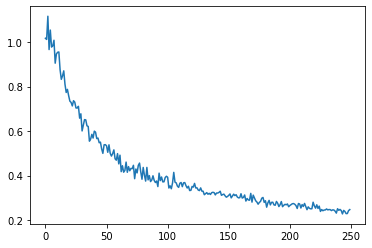

In [5]:
plt.plot(r_list)

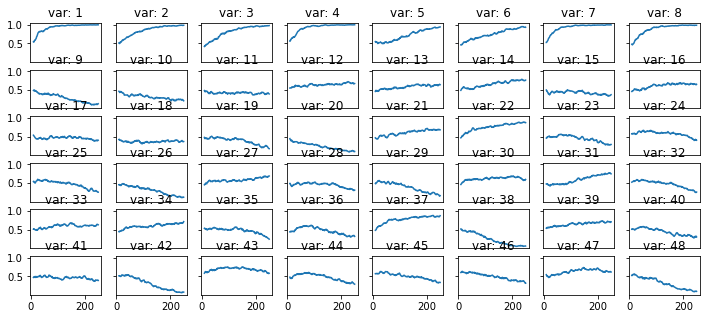

In [6]:
fig, axes = plt.subplots(int(n/8), 8, figsize=(12, 5), sharex=False, sharey=True)
# plt.subplots_adjust(
# top=0.965,
# bottom=0.09,
# left=0.03,
# right=0.83,
# hspace=0.52,
# wspace=0.18)
# fig.tight_layout()
num = 0
for i in range(int(n/8)):
    for j in range(8):
        axes[i, j].plot(pd.Series(np.array(action_select)[:, num]).rolling(10).mean())
        axes[i, j].set_title(f'var: {num+1}')
        if i != int(n/8)-1: axes[i, j].set_xticks([]) 
        num += 1

In [7]:
with torch.no_grad():
    actions, log_probs, _ = actor(X)

In [9]:
print(np.where(np.array(action_select)[-10:, ].mean(axis=0) >= 0.9)[0])
print(np.where(actions.mean(axis=0) >= 0.9)[0])

[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7]


# Natural Policy Gradient

In [3]:
def compute_reward(X_train, Y_train, X_test, Y_test, actions, hiddens=(128, ), num_iter=500, lr=1e-3, batch_size='auto', dictionary=dict()):
    reward_list = []
    for i, action in enumerate(actions):
        
        idx = np.where(action == 1)[0]
        
        if tuple(idx) in dictionary:
            reward_list.append(dictionary[tuple(idx)])
        else:
            X_select = X_train[:, idx]        
            reg_clf = MLPRegressor(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
                                     learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
#             reg_clf = LinearRegression(fit_intercept=False)
#             reg_clf = Ridge(alpha=0.05, fit_intercept=False)
            # reg_clf = RandomForestRegressor(n_estimators=50)
#             reg_clf = ExtraTreesRegressor(n_estimators=50)
#             reg_clf = MLPClassifier(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
#                                      learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
            # reg_clf = RandomClassifier(n_estimators=50, max_depth=5)
#             reg_clf = ExtraTreesClassifier(n_estimators=50, max_depth=5)
            reg_clf.fit(X_select, Y_train)
            X_select = X_test[:, idx] 
            score = reg_clf.score(X_select, Y_test)
            # mse = np.mean((Y_test - regressor.predict(X_select))**2)
            dictionary[tuple(idx)] = score
            reward_list.append(score)
        
    return np.array(reward_list)

In [4]:
start = time.time()
# training steps
m = 200                  # linear case, n=300, 样本量为100可以，但是当变成200时就不行了...
n = 50
signal = 1
sigma = 0.5
num_support = 8
batch_size = 64

seed = 12
np.random.seed(seed)
torch.manual_seed(seed)

X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=seed)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)


# actor = Actor(obs_dim=n, action_dim=n)
# actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)   # 不能太大了，1e-2就不行



r_list = []
r_baseline = 0
dictionary = dict()
theta = np.zeros(n) + 0.5
p_list = []
w_norm = []

for step in range(250):               # hierarchical # feature=50, 150,    quadratic mlp 256, 120
    print('step: ', step)
    
    p_list.append(theta)
#     idx_select = np.where(theta > 0.9)[0]
    
    actions = np.zeros((batch_size, n))
    p = torch.from_numpy(theta)
    for i in range(batch_size):
        action = torch.bernoulli(p)
        if action.sum == 0:
            idx = np.random.randint(0, n, int(n/3))
            action[idx] = 1
        actions[i, :] = action.numpy()
#         idx = np.random.choice(np.where(action == 1)[0], 5, replace=False)
#         tmp = np.zeros(n)
#         tmp[idx] = 1
#         tmp[idx_select] = 1
#         actions[i, :] = tmp
        
    
    
    rewards = compute_reward(x_train, y_train, x_test, y_test, actions, hiddens=(128, ), num_iter=200, lr=1e-2, batch_size='auto', dictionary=dictionary)
    r_list.append(rewards.mean())
    print(f'average reward: {rewards.mean()}')
#     rewards = torch.tensor(rewards, dtype=torch.float32)
    
#     r_baseline = 0.95 * r_baseline + 0.05 * rewards.mean()
#     rewards -= r_baseline
    # sampled natural policy gradient
    log_pi_grad = actions / theta - (1 - actions)/(1 - theta)
#     log_pi_grad = log_pi_grad.numpy()
    
    reg = Ridge(alpha=0.05)                    # 非常意外，如果使用了fit_intercept=False, 结果反而不好，而且使用linearRegressor也不行
    reg.fit(log_pi_grad, rewards)
    w = reg.coef_
    
    w_norm.append(np.linalg.norm(w))
    
    theta = theta + 1 * w    
    theta = np.clip(theta, 0.02, 0.98)
    
#     if step > 100:
#         theta = np.where(theta < 0.4, 0.02, theta)
        


#     if step > 6:
#         if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
#             & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
#             print(f'converge at step {step}')
#             break

    if np.linalg.norm(theta - p_list[-1]) < 1e-3:
        print(f'converge at step {step}')
        break

end = time.time()

print(datetime.timedelta(seconds=end - start))

step:  0
average reward: 0.053865984341110854
step:  1
average reward: 0.15269105813432235
step:  2
average reward: 0.2611092780198336
step:  3
average reward: 0.25773443616678143
step:  4
average reward: 0.29982774409071367
step:  5
average reward: 0.3445986223374547
step:  6
average reward: 0.38185532650745685
step:  7
average reward: 0.3839349765480782
step:  8
average reward: 0.4752633187986668
step:  9
average reward: 0.5120039607129305
step:  10
average reward: 0.5395010240327979
step:  11
average reward: 0.5125968667519564
step:  12
average reward: 0.5210449256208133
step:  13
average reward: 0.5426028398252825
step:  14
average reward: 0.5424192770315523
step:  15
average reward: 0.5372344654576071
step:  16
average reward: 0.5727479188838224
step:  17
average reward: 0.49001401973935044
step:  18
average reward: 0.5540439888400904
step:  19
average reward: 0.5280127993639926
step:  20
average reward: 0.5758881630302005
step:  21
average reward: 0.5390989597229092
step:  22
ave

average reward: 0.7366355106673457
step:  182
average reward: 0.7389097593510887
step:  183
average reward: 0.7437941674623477
step:  184
average reward: 0.6945718487449548
step:  185
average reward: 0.7543709650588756
step:  186
average reward: 0.7132147697161657
step:  187
average reward: 0.7160184899277863
step:  188
average reward: 0.739422189096803
step:  189
average reward: 0.741845142360507
step:  190
average reward: 0.7585436534801557
step:  191
average reward: 0.7297475425852935
step:  192
average reward: 0.7132806013133257
step:  193
average reward: 0.7460354061448934
step:  194
average reward: 0.7713949616115932
step:  195
average reward: 0.7076660031453467
step:  196
average reward: 0.7716187853439549
step:  197
average reward: 0.7451141955573403
step:  198
average reward: 0.7664570225125683
step:  199
average reward: 0.7337563761636312
step:  200
average reward: 0.7602868512052061
step:  201
average reward: 0.7396435408644774
step:  202
average reward: 0.7346568360023596
s

[0.98 0.98 0.96 0.98 0.97 0.95 0.98 0.98 0.03 0.04 0.03 0.47 0.28 0.02
 0.02 0.13 0.02 0.09 0.09 0.02 0.35 0.88 0.19 0.03 0.02 0.03 0.78 0.05
 0.07 0.1  0.35 0.15 0.27 0.98 0.36 0.34 0.38 0.03 0.02 0.06 0.33 0.03
 0.03 0.03 0.06 0.24 0.06 0.02 0.48 0.03]
[ 0  1  2  3  4  5  6  7 33]
[ 0  1  6  7  3 33  4  2  5 21 26 48 11 36 34 30 20 35 40 12 32 45 22 31
 15 29 18 17 28 39 44 46 27  9 42 49 25 23 43 41  8 10 37 13 47 14 16 19
 38 24]


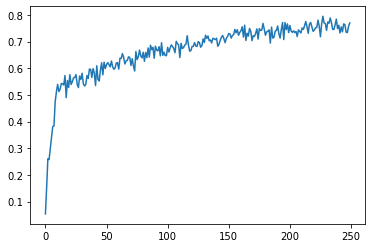

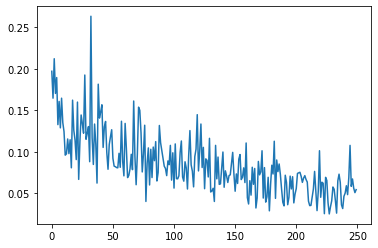

In [5]:
plt.plot(r_list)
print(np.round(theta, 2))
print(np.where(theta > 0.90)[0])
print(np.argsort(theta)[::-1])
plt.figure()
plt.plot(w_norm)

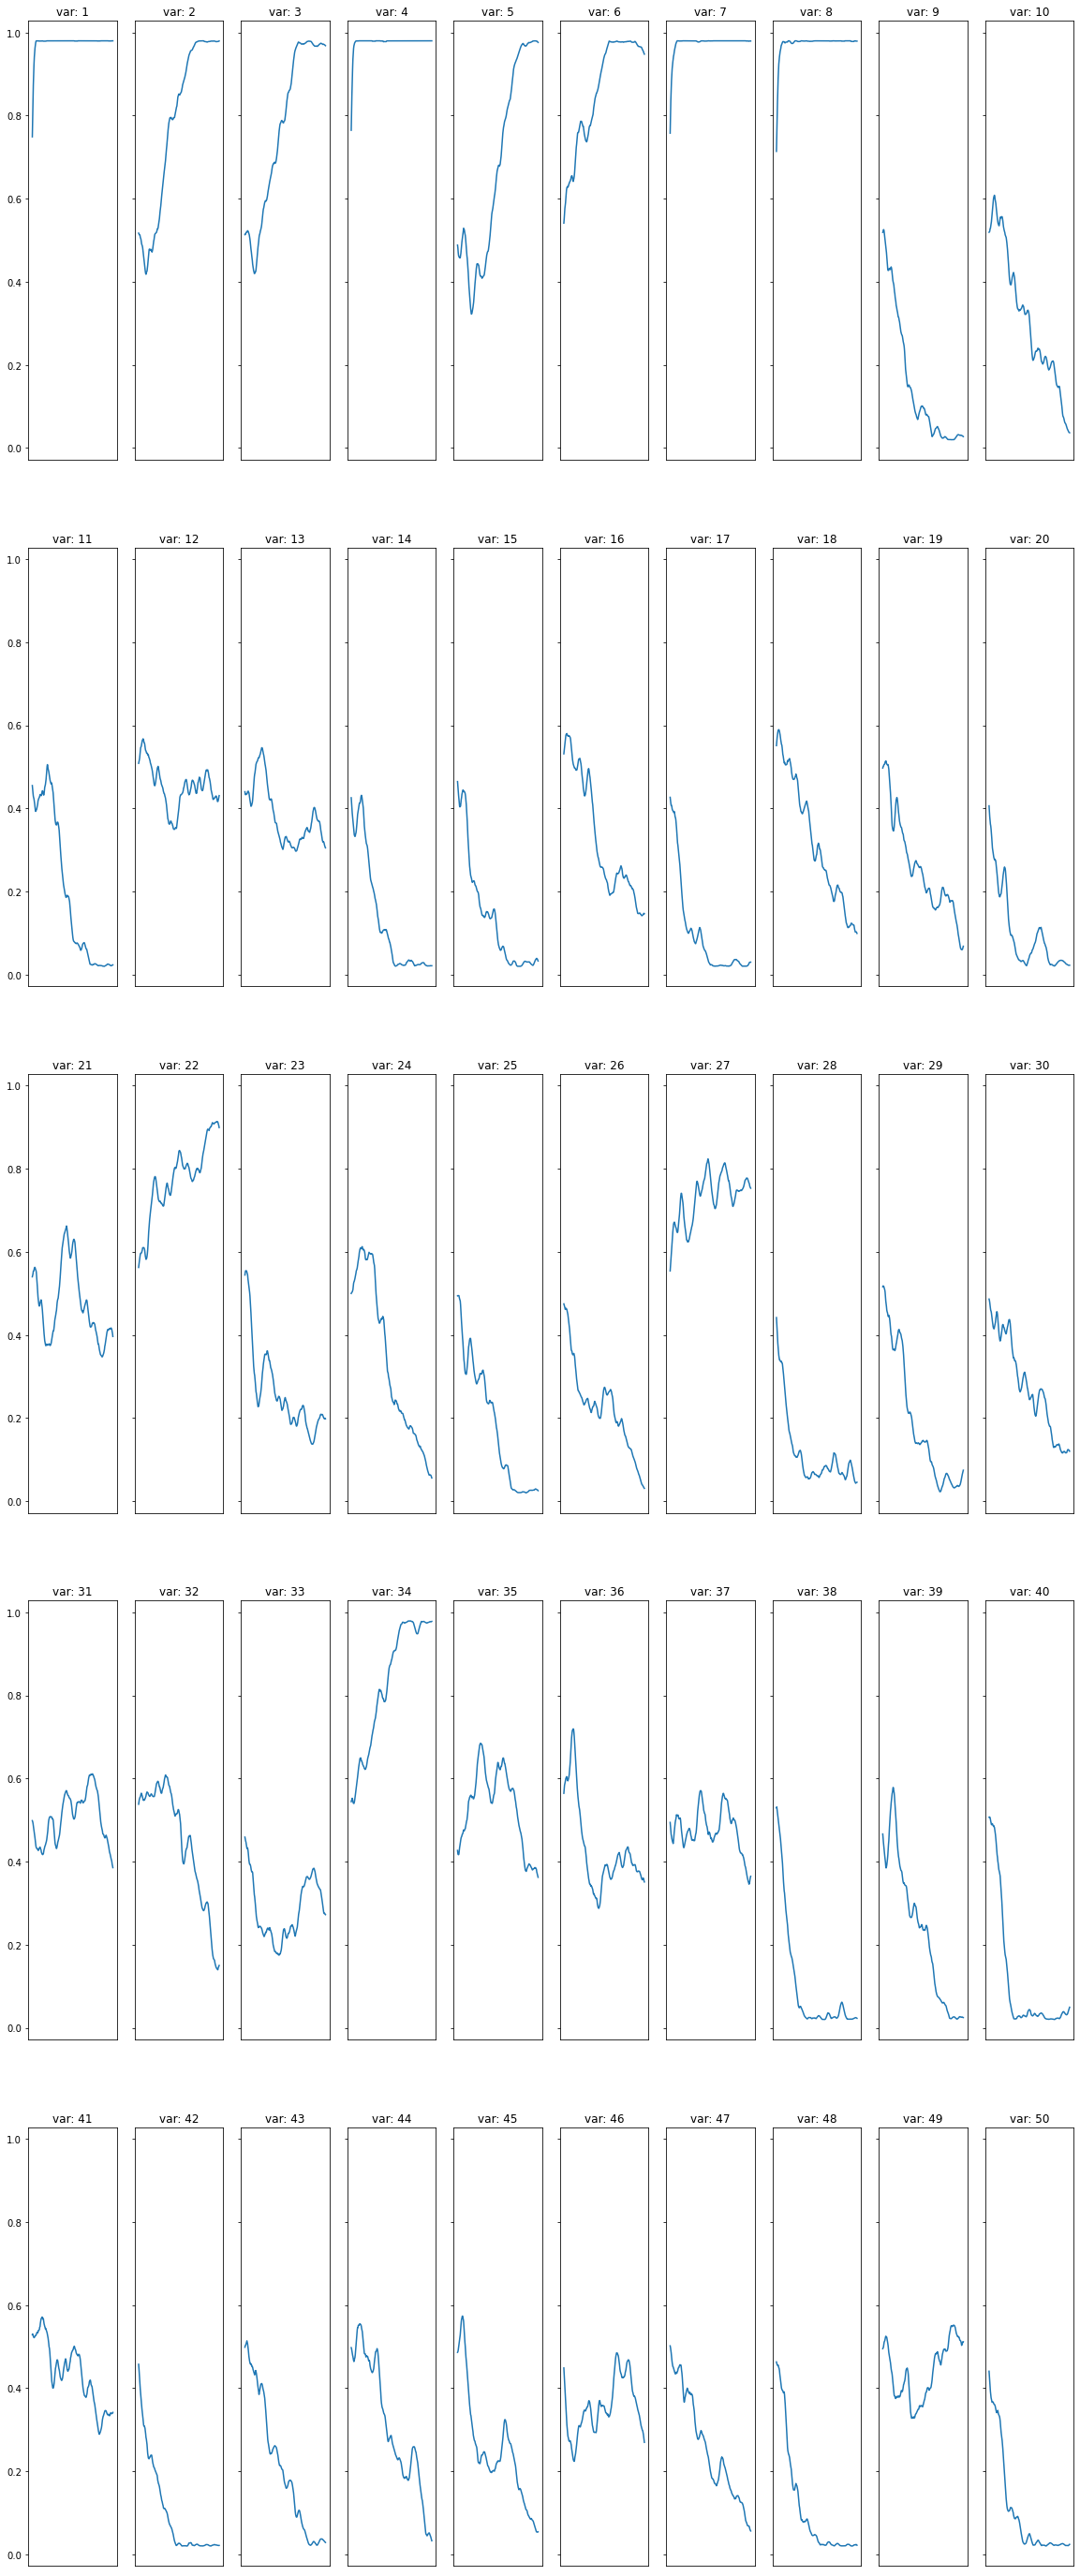

In [6]:
probs = np.array(p_list)
fig, axes = plt.subplots(int(n/10+0.9), 10, figsize=(20, 50), sharex=False, sharey=True)
# plt.subplots_adjust(
# top=0.965,
# bottom=0.09,
# left=0.03,
# right=0.83,
# hspace=0.52,
# wspace=0.18)
# fig.tight_layout()
num = 0
for i in range(int(n/10+0.9)):
    for j in range(10):
        axes[i, j].plot(pd.Series(np.array(probs)[:, num]).rolling(10).mean())
        axes[i, j].set_title(f'var: {num+1}')
        if i != int(n/8)-1: axes[i, j].set_xticks([]) 
        num += 1

In [188]:
print('npg')
print(np.where(theta > 0.90)[0] + 1)

print('lasso_aic')
lasso_aic = LassoLarsIC(criterion='aic', fit_intercept=False, normalize=False)
lasso_aic.fit(X, Y)
print(np.where(lasso_aic.coef_ != 0)[0] + 1)

print('lasso_bic')
from sklearn.linear_model import Lasso, LassoLarsIC, LassoCV
lasso_bic = LassoLarsIC(criterion='bic', fit_intercept=False, normalize=False)
lasso_bic.fit(X, Y)
print(np.where(lasso_bic.coef_ != 0)[0] + 1)

print('lasso_cv')
lasso_cv = LassoCV(cv=5, fit_intercept=False)
lasso_cv.fit(X, Y)
print(np.where(lasso_cv.coef_ != 0)[0] + 1)

print('random_forest')
rf = RandomForestRegressor(max_depth=5, random_state=seed)    
rf.fit(X, Y)
sfm = SelectFromModel(rf, prefit=True)
print(np.arange(n)[sfm.get_support()] + 1)

npg
[ 1  4  7  8 33]
lasso_aic
[ 1  3  4  7  8 19 21 22 25 28 32 33 38 42 47]
lasso_bic
[1 4 7 8]
lasso_cv
[ 1  3  4  7  8 19 21 22 25 28 32 33 38 42 47]
random_forest
[1 2 4 7 8]


In [189]:
print(np.where(theta > 0.9)[0])

num_selected = 8

npg = np.argsort(theta)[::-1][:num_selected]
print('npg: ', np.sort(npg))


lasso_aic = LassoLarsIC(criterion='aic', fit_intercept=False, normalize=False, noise_variance=np.std(Y))
lasso_aic.fit(X, Y)
aic = np.where(lasso_aic.coef_ != 0)[0]
print('lasso_aic: ', aic)


lasso_bic = LassoLarsIC(criterion='bic', fit_intercept=False, normalize=False, noise_variance=np.std(Y))
lasso_bic.fit(X, Y)
bic = np.where(lasso_bic.coef_ != 0)[0]
print('lasso_bic: ', bic)

print('lasso_cv')
lasso_cv = LassoCV(cv=5, fit_intercept=False, max_iter=3000)
lasso_cv.fit(X, Y)
print(np.where(lasso_cv.coef_ != 0)[0])


regr = RandomForestRegressor()
regr.fit(X, Y)
rf = np.argsort(regr.feature_importances_)[::-1][:num_selected]
print('random_forest: ', np.sort(rf))

[ 0  3  6  7 32]
npg:  [ 0  3  6  7 12 21 32 36]
lasso_aic:  [ 0  3  6  7 24 27 46]
lasso_bic:  [0 3 6 7]
lasso_cv
[ 0  2  3  6  7 18 20 21 24 27 31 32 37 41 46]
random_forest:  [ 0  1  3  6  7 10 31 39]


In [336]:
?LassoCV

In [33]:
import sklearn
sklearn.__version__

'1.0.2'

## run different seeds

In [19]:
# training steps
m = 200
n = 50
sigma = 0.5
num_support = 8
signal = 1
y_true = np.zeros(n, dtype=int)
y_true[:num_support] = 1
batch_size = 64

def run(seed):
    start = time.time()
    print(f'random seed: {seed} is running')
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=seed)   
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
    
    
        
    r_list = []
    r_baseline = 0
    dictionary = dict()
    theta = np.zeros(n) + 0.5
    p_list = []
#     w_norm = []
    
    for step in range(100):
        # print('step: ', step)
        
        p_list.append(theta)
        actions = np.zeros((batch_size, n))
        p = torch.from_numpy(theta)
        for i in range(batch_size):
            action = torch.bernoulli(p)
            if action.sum() == 0:
                idx = np.random.randint(0, n, int(n/3))
                action[idx] = 1
            actions[i, :] = action.numpy()



        rewards = compute_reward(x_train, y_train, x_test, y_test, actions, hiddens=(128, ), num_iter=1000, lr=1e-2, batch_size=batch_size, dictionary=dictionary)
        r_list.append(rewards.mean())
#         print(f'average reward: {rewards.mean()}')
    #     rewards = torch.tensor(rewards, dtype=torch.float32)

        # r_baseline = 0.95 * r_baseline + 0.05 * rewards.mean()

        # sampled natural policy gradient
        log_pi_grad = actions / theta - (1 - actions)/(1 - theta)


        reg = Ridge(alpha=0.05)
        reg.fit(log_pi_grad, rewards)
        w = reg.coef_

#         w_norm.append(np.linalg.norm(w))

        theta = theta + 1 * w    
        theta = np.clip(theta, 0.02, 0.98)


    #     if step > 6:
    #         if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
    #             & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
    #             print(f'converge at step {step}')
    #             break

        if np.linalg.norm(theta - p_list[-1]) < 1e-3:
            print(f'converge at step {step}')
            break
            
    
#     tmp = sorted(dictionary.items(), key=lambda x: x[1])
#     s = set(range(n))
#     for item in tmp[:10]:
#         s = s & set(item[0])
    # print(s)
    
                        
#     y_pred_rl1 = np.where(action_select[-10:].mean(axis=0) >= 0.9, 1, 0)
#     y_pred_rl2 = np.where(actions.mean(dim=0) >= 0.9, 1, 0)
#     y_pred_rl1 = action_select[-10:].mean(axis=0)
#     y_pred_rl2 = actions.mean(dim=0).numpy()
    y_pred_rl1 = theta
#     y_pred_rl3 = np.where([i in s for i in range(n)], 1, 0)
    
    
    lasso_aic = LassoLarsIC(criterion='aic', fit_intercept=False, normalize=False)
    lasso_aic.fit(X, Y)
    y_pred_aic = lasso_aic.coef_
    lasso_bic = LassoLarsIC(criterion='bic', fit_intercept=False, normalize=False)
    lasso_bic.fit(X, Y)
    y_pred_bic = lasso_bic.coef_
    lasso_cv = LassoCV(cv=5, fit_intercept=False)
    lasso_cv.fit(X, Y)
    y_pred_cv = lasso_cv.coef_
    rf = RandomForestRegressor(random_state=seed)    
    rf.fit(X, Y)
    y_pred_rf = rf.feature_importances_
    
    dat = np.vstack((y_pred_rl1, y_pred_aic, y_pred_bic, y_pred_cv, y_pred_rf))
    
    
    print('npg', np.argsort(theta)[::-1][:8])
    print('lasso aic', np.argsort(y_pred_aic)[::-1][:8])
    print('lasso bic', np.argsort(y_pred_bic)[::-1][:8])
    print('lasso cv', np.argsort(y_pred_cv)[::-1][:8])
    print('random forest', np.argsort(y_pred_rf)[::-1][:8])
    
    
    # cm1 = confusion_matrix(y_true, y_pred_rl1)
    # cm2 = confusion_matrix(y_true, y_pred_rl2)
    # cm_bic = confusion_matrix(y_true, y_pred_bic)
    # cm_aic = confusion_matrix(y_true, y_pred_aic)
    # # return cm1, cm2, cm_bic, cm_aic
    
    # dat = pd.DataFrame(np.zeros((3, 4)), index=['precision', 'specificity', 'recall'])
    #                     # columns=['cm1', 'cm2', 'bic', 'aic'])
    
    # for i, cm in enumerate([cm1, cm2, cm_bic, cm_aic]):
    #     tn, fp, fn, tp = cm.ravel()
    #     dat.loc['precision', i] = tp/(tp+fn)
    #     dat.loc['specificity', i] = tn/(tn+fp)
    #     dat.loc['recall', i] = 0 if tp + fp == 0 else tp/(tp+fp)
        
    # dat.columns = ['cm1', 'cm2', 'bic', 'aic']
    
    
#     regr = LogisticRegression(penalty='l2', fit_intercept=False, max_iter=1e6)
#     regr.fit(X, Y)
#     sfm = SelectFromModel(regr, prefit=True)
#     y_pred_log = np.where(sfm.get_support(), 1, 0)
    
    
    end = time.time()
    print(f'rd: {seed} take {datetime.timedelta(seconds = end - start)}')
    
    return dat

In [20]:
if __name__ == '__main__':
    start = time.time()
    dats = []
    for sd in tqdm(range(50)):
        dats.append(run(sd))

#     print("CPU的核数为：{}".format(mp.cpu_count()))

#     pool = mp.Pool(2)
#     dats = pool.map(run, range(50))
#     pool.close()
    end = time.time()
    print(datetime.timedelta(seconds = end - start))
    
    
    dats = np.array([dat for dat in dats])


  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

random seed: 0 is running



  2%|███▍                                                                                                                                                                      | 1/50 [00:08<06:34,  8.05s/it]

npg [ 0  3  6  7 33 20 25 23]
lasso aic [ 6  0  7  3 29 23  5  2]
lasso bic [ 6  0  7  3 13 22 21 19]
lasso cv [ 6  0  7  3 23 29  4  5]
random forest [ 0  6  3  7 23 29  5 18]
rd: 0 take 0:00:08.044471
random seed: 1 is running



  4%|██████▊                                                                                                                                                                   | 2/50 [00:16<06:27,  8.07s/it]

npg [ 0  3  6  7 43 38 15 40]
lasso aic [ 7  6  0  3 16 30 48 40]
lasso bic [ 7  6  3  0 16 13 22 21]
lasso cv [ 7  6  0  3 16 30 48 40]
random forest [ 7  6  3  0 23 34 17 37]
rd: 1 take 0:00:08.078123
random seed: 2 is running



  6%|██████████▏                                                                                                                                                               | 3/50 [00:23<06:14,  7.98s/it]

npg [ 0  3  6  7  4 17 15 46]
lasso aic [ 3  6  7  0 17 15 14 22]
lasso bic [ 3  6  7  0 14 22 21 20]
lasso cv [ 3  6  7  0 15 17  5 32]
random forest [ 3  6  7  0 18  4  5 22]
rd: 2 take 0:00:07.867060
random seed: 3 is running



  8%|█████████████▌                                                                                                                                                            | 4/50 [00:32<06:13,  8.11s/it]

npg [ 0  3  6  7 11  1 40 25]
lasso aic [ 7  0  3  6 11 40 25 15]
lasso bic [ 7  0  3  6 11 40  5 15]
lasso cv [ 7  0  3  6 11 40 25 15]
random forest [ 0  7  3  6  1 45 46  5]
rd: 3 take 0:00:08.310760
random seed: 4 is running



 10%|█████████████████                                                                                                                                                         | 5/50 [00:40<06:05,  8.13s/it]

npg [ 0  7  3  6 49 27 48 28]
lasso aic [ 0  3  7  6 49 38 25 35]
lasso bic [ 0  3  7  6 49 44 21 19]
lasso cv [ 0  3  7  6 49 38 25 35]
random forest [ 0  3  6  7  1  2 12 49]
rd: 4 take 0:00:08.150188
random seed: 5 is running



 12%|████████████████████▍                                                                                                                                                     | 6/50 [00:48<05:59,  8.18s/it]

npg [ 0  3  6  7 33 28 18 34]
lasso aic [ 7  3  6  0 34 28 18 21]
lasso bic [ 7  3  0  6 34 13 21 20]
lasso cv [ 7  3  6  0 34 28 18 13]
random forest [ 7  3  0  6 34 31  4 27]
rd: 5 take 0:00:08.270863
random seed: 6 is running



 14%|███████████████████████▊                                                                                                                                                  | 7/50 [00:56<05:49,  8.14s/it]

npg [ 0  6  7  3 43 28 15  4]
lasso aic [ 0  7  3  6  4 45  2 31]
lasso bic [ 0  7  3  6 13 22 21 20]
lasso cv [ 0  7  3  6  4 45  2 31]
random forest [ 0  3  7  6 43  2  4 28]
rd: 6 take 0:00:08.059463
random seed: 7 is running



 16%|███████████████████████████▏                                                                                                                                              | 8/50 [01:04<05:38,  8.06s/it]

npg [ 0  6  7  3  5 41 28 15]
lasso aic [ 3  6  0  7  5 47 40 29]
lasso bic [ 3  6  7  0  5 14 22 21]
lasso cv [ 3  6  0  7  5 47 40 29]
random forest [ 3  6  7  0 26 17 46 47]
rd: 7 take 0:00:07.895936
random seed: 8 is running



 18%|██████████████████████████████▌                                                                                                                                           | 9/50 [01:13<05:46,  8.45s/it]

npg [ 0  3  7  4 23  6 24 43]
lasso aic [ 7  0  3  6  4 24 38 43]
lasso bic [ 7  0  3  6 13 21 20 19]
lasso cv [ 7  0  3  6  4 24 38 43]
random forest [ 7  6  3  0  4 33 10  1]
rd: 8 take 0:00:09.291186
random seed: 9 is running



 20%|█████████████████████████████████▊                                                                                                                                       | 10/50 [01:21<05:31,  8.29s/it]

npg [ 0  3  6  7  8  4 40  2]
lasso aic [ 6  7  3  0 33 40  2 14]
lasso bic [ 6  3  7  0 33 13 21 20]
lasso cv [ 6  3  7  0 33 40 14 21]
random forest [ 3  6  7  0 11 37  2 16]
rd: 9 take 0:00:07.928805
random seed: 10 is running



 22%|█████████████████████████████████████▏                                                                                                                                   | 11/50 [01:30<05:23,  8.31s/it]

npg [ 0  3  6  7  1 32 25 45]
lasso aic [ 7  0  3  6 17  9 12 18]
lasso bic [ 7  0  3  6 14 22 21 20]
lasso cv [ 7  0  3  6 17  9 12 18]
random forest [ 7  0  6  3 34  1 30  2]
rd: 10 take 0:00:08.345216
random seed: 11 is running



 24%|████████████████████████████████████████▌                                                                                                                                | 12/50 [01:38<05:12,  8.22s/it]

npg [ 0  3  6  7 44 24 27 43]
lasso aic [ 7  6  3  0 44 43 31 14]
lasso bic [ 7  3  6  0 13 22 21 20]
lasso cv [ 7  6  3  0 44 43 48 14]
random forest [ 6  3  7  0 19 12 35 48]
rd: 11 take 0:00:08.023083
random seed: 12 is running



 26%|███████████████████████████████████████████▉                                                                                                                             | 13/50 [01:46<05:02,  8.19s/it]

npg [ 0  3  6  7 32 31 21 24]
lasso aic [ 3  0  6  7 27 37 18 41]
lasso bic [ 3  0  6  7 13 22 21 20]
lasso cv [ 3  0  6  7 27 37 18 41]
random forest [ 3  0  6  7  1 23 31 24]
rd: 12 take 0:00:08.106381
random seed: 13 is running



 28%|███████████████████████████████████████████████▎                                                                                                                         | 14/50 [01:54<04:50,  8.08s/it]

npg [ 0  3  6  7 37 45 13 33]
lasso aic [ 6  0  7  3 37 28 13 34]
lasso bic [ 6  7  0  3 37  4  5 21]
lasso cv [ 6  0  7  3 37 28 13 34]
random forest [ 6  7  0  3 10 43 28  5]
rd: 13 take 0:00:07.827125
random seed: 14 is running



 30%|██████████████████████████████████████████████████▋                                                                                                                      | 15/50 [02:02<04:40,  8.02s/it]

npg [ 0  3  6  7 28  8 33 35]
lasso aic [ 3  6  0  7 40 28  5  8]
lasso bic [ 3  6  0  7 40 13 21 20]
lasso cv [ 3  6  0  7 40 28  5 33]
random forest [ 3  6  0  7 29 48 19 32]
rd: 14 take 0:00:07.871482
random seed: 15 is running



 32%|██████████████████████████████████████████████████████                                                                                                                   | 16/50 [02:09<04:30,  7.96s/it]

npg [ 0  3  6  7 17 46  2 24]
lasso aic [ 6  0  3  7 17 41 14 22]
lasso bic [ 6  0  3  7 14 22 21 20]
lasso cv [ 6  0  3  7 17 41 27 42]
random forest [ 6  0  3  7  4 13 44 46]
rd: 15 take 0:00:07.810068
random seed: 16 is running



 34%|█████████████████████████████████████████████████████████▍                                                                                                               | 17/50 [02:17<04:22,  7.95s/it]

npg [ 0  3  6  7 48 37 40 26]
lasso aic [ 0  6  3  7 28 15 14 23]
lasso bic [ 0  6  3  7 15 28 14 22]
lasso cv [ 0  3  6  7 28 15 14 23]
random forest [ 0  6  3  7  5  1 36 15]
rd: 16 take 0:00:07.947349
random seed: 17 is running



 36%|████████████████████████████████████████████████████████████▊                                                                                                            | 18/50 [02:26<04:17,  8.04s/it]

npg [ 0  3  6  7 43 38 21 33]
lasso aic [ 6  3  7  0 26 13  2 43]
lasso bic [ 6  3  0  7  2 43 14 22]
lasso cv [ 6  3  0  7 26  2 43 13]
random forest [ 6  3  0  7 30 49  4  1]
rd: 17 take 0:00:08.250581
random seed: 18 is running



 38%|████████████████████████████████████████████████████████████████▏                                                                                                        | 19/50 [02:34<04:10,  8.07s/it]

npg [ 0  3  7  6  5 23 29 31]
lasso aic [ 0  3  6  7  5 23 11 41]
lasso bic [ 0  3  6  7  5 23  4  1]
lasso cv [ 0  3  6  7  5 23 11 41]
random forest [ 0  3  6  7  2 25 31  5]
rd: 18 take 0:00:08.137794
random seed: 19 is running



 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 20/50 [02:42<04:04,  8.16s/it]

npg [ 0  3  6  7 35 38 39 32]
lasso aic [ 7  6  3  0 27 15 23 21]
lasso bic [ 7  6  3  0 13 22 21 20]
lasso cv [ 7  6  3  0 14 22 21 20]
random forest [ 7  3  6  0 36  2  5 26]
rd: 19 take 0:00:08.346732
random seed: 20 is running



 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 21/50 [02:50<03:52,  8.03s/it]

npg [ 3  6  7  9  0 31  8 48]
lasso aic [ 3  7  6  0 31  8 15 22]
lasso bic [ 3  7  6  0 31 13 21 20]
lasso cv [ 3  7  6  0 31 14 22 21]
random forest [ 3  7  6  0  2  1 44 39]
rd: 20 take 0:00:07.729160
random seed: 21 is running



 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                              | 22/50 [02:58<03:42,  7.93s/it]

npg [ 0  3  6  7 26  4 19 20]
lasso aic [ 3  0  7  6 20 14 22 21]
lasso bic [ 3  0  7  6 14 22 21 20]
lasso cv [ 3  0  7  6 14 22 21 20]
random forest [ 6  3  7  0  4  5 22 35]
rd: 21 take 0:00:07.707005
random seed: 22 is running



 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                           | 23/50 [03:05<03:33,  7.92s/it]

npg [ 0  3  6  7  1 39 21 18]
lasso aic [ 3  0  7  6 24 21 28  2]
lasso bic [ 0  3  6  7 13 22 21 20]
lasso cv [ 0  3  7  6 24 44 11 20]
random forest [ 0  3  6  7  2  5  1 20]
rd: 22 take 0:00:07.879009
random seed: 23 is running



 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                        | 24/50 [03:13<03:24,  7.88s/it]

npg [ 0  7  6  3  4 37  5 38]
lasso aic [ 7  0  3  6 37 20 31 43]
lasso bic [ 7  0  3  6 13 22 21 20]
lasso cv [ 7  0  3  6 37 20 31 43]
random forest [ 7  3  0  6  4  5  2 16]
rd: 23 take 0:00:07.786443
random seed: 24 is running



 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 25/50 [03:21<03:19,  7.98s/it]

npg [ 0  3  6  7 37 31 40  5]
lasso aic [ 0  6  7  3 31  5 38 40]
lasso bic [ 0  6  7  3 38 14 22 21]
lasso cv [ 0  6  7  3 38  5 31 40]
random forest [ 0  6  7  3  2 40  1  4]
rd: 24 take 0:00:08.217977
random seed: 25 is running



 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 26/50 [03:30<03:12,  8.03s/it]

npg [ 0  3  6  7 18 37 22 38]
lasso aic [ 3  0  7  6  2 22 37  4]
lasso bic [ 3  0  7  6 13 22 21 20]
lasso cv [ 3  0  7  6  2 22 37 14]
random forest [ 3  7  0  6 22 34 49  1]
rd: 25 take 0:00:08.139216
random seed: 26 is running



 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 27/50 [03:37<03:03,  7.98s/it]

npg [ 0  7  3  6  8 44 14 43]
lasso aic [ 6  0  3  7  8 22 33 17]
lasso bic [ 6  0  3  7 15 23 22 21]
lasso cv [ 6  0  3  7  8 22 33 16]
random forest [ 6  3  0  7 23 33 48  4]
rd: 26 take 0:00:07.849592
random seed: 27 is running



 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 28/50 [03:46<02:57,  8.06s/it]

npg [ 0  3  6  7 44 17 18 10]
lasso aic [ 3  7  6  0 25 29 18 13]
lasso bic [ 3  7  6  0 25 29 14 21]
lasso cv [ 3  7  6  0 25 29 13 35]
random forest [ 7  3  6  0 47 39 37 42]
rd: 27 take 0:00:08.266846
random seed: 28 is running



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 29/50 [03:54<02:49,  8.09s/it]

npg [ 0  3  6  7 39 11 17 26]
lasso aic [ 7  3  0  6 26 14 22 21]
lasso bic [ 7  3  0  6 26 14 22 21]
lasso cv [ 7  3  0  6 26 34 31 24]
random forest [ 0  3  7  6 40  2 26 12]
rd: 28 take 0:00:08.145201
random seed: 29 is running



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 30/50 [04:02<02:41,  8.06s/it]

npg [ 0  7  3  6 18 48 25 39]
lasso aic [ 6  0  7  3 12 29 14 21]
lasso bic [ 6  0  7  3 13 22 21 20]
lasso cv [ 6  0  7  3 12 29 42 14]
random forest [ 0  6  7  3  5 39 30 11]
rd: 29 take 0:00:07.982602
random seed: 30 is running



 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 31/50 [04:10<02:31,  8.00s/it]

npg [ 0  7  6  3 46  5 40  1]
lasso aic [ 0  7  6  3 18 46 40  1]
lasso bic [ 7  0  6  3 18 40 13 21]
lasso cv [ 0  7  6  3 18 46 40  1]
random forest [ 3  7  6  0  1 22 45 18]
rd: 30 take 0:00:07.857553
random seed: 31 is running



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 32/50 [04:18<02:24,  8.02s/it]

npg [ 0  3  7  6 22 11 25 23]
lasso aic [ 7  0  3  6 22 11  4 13]
lasso bic [ 7  0  3  6  4 11 22  5]
lasso cv [ 7  0  3  6 11  4 22 20]
random forest [ 7  0  6  3  5 27  4 13]
rd: 31 take 0:00:08.061974
random seed: 32 is running



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 33/50 [04:26<02:17,  8.11s/it]

npg [ 0  7  6  3 43 19 25 40]
lasso aic [ 7  3  0  6 19 43 30 25]
lasso bic [ 3  7  0  6 19 43 13 21]
lasso cv [ 7  3  0  6 19 43 30 25]
random forest [ 7  3  0  6  1 27  5 48]
rd: 32 take 0:00:08.334142
random seed: 33 is running



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 34/50 [04:34<02:09,  8.11s/it]

npg [ 0  3  6  7 48 20 19 36]
lasso aic [ 7  3  6  0 31 21  8 36]
lasso bic [ 7  3  0  6 13 22 21 19]
lasso cv [ 7  3  0  6 21 31  8 10]
random forest [ 3  7  0  6  2 20 48  4]
rd: 33 take 0:00:08.103312
random seed: 34 is running



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 35/50 [04:42<02:01,  8.10s/it]

npg [ 0  3  6  7 41  4 14 13]
lasso aic [ 0  7  6  3 33 14 22 21]
lasso bic [ 0  7  3  6 33 13 21 20]
lasso cv [ 0  7  6  3 33 14 13 21]
random forest [ 3  0  6  7 49 41 35 13]
rd: 34 take 0:00:08.053446
random seed: 35 is running



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 36/50 [04:50<01:51,  7.96s/it]

npg [ 0  3  6  7 23 40 20 42]
lasso aic [ 0  7  6  3  4 23  5 15]
lasso bic [ 0  7  6  3 13 22 21 20]
lasso cv [ 0  7  6  3  4 14 22 21]
random forest [ 7  0  6  3 23  1 29 40]
rd: 35 take 0:00:07.649379
random seed: 36 is running



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 37/50 [04:58<01:43,  7.99s/it]

npg [ 0  6  3  7 16 39 28 27]
lasso aic [ 7  3  6  0 22  4 36 11]
lasso bic [ 7  3  6  0 13 23 22 21]
lasso cv [ 7  3  0  6 22  4 11 36]
random forest [ 7  3  6  0 13 48  2 11]
rd: 36 take 0:00:08.041450
random seed: 37 is running



 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 38/50 [05:06<01:35,  7.99s/it]

npg [ 0  3  6  7 20 21 49  2]
lasso aic [ 0  3  6  7 20 13 22 21]
lasso bic [ 0  3  6  7 20 13 22 21]
lasso cv [ 0  3  6  7 20 13 22 21]
random forest [ 0  3  7  6  4 39 44  1]
rd: 37 take 0:00:08.004129
random seed: 38 is running



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 39/50 [05:14<01:27,  7.97s/it]

npg [ 0  3  6  7 15 10  1 36]
lasso aic [ 3  7  0  6 36 24 15 43]
lasso bic [ 3  7  0  6 36 13 21 20]
lasso cv [ 3  7  0  6 36 24 43 42]
random forest [ 3  7  0  6  1 37  8 48]
rd: 38 take 0:00:07.928326
random seed: 39 is running



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 40/50 [05:22<01:18,  7.89s/it]

npg [ 0  3  6  7 34 28 33 31]
lasso aic [ 7  0  3  6 34 28 13 16]
lasso bic [ 7  0  3  6 34 28 21 20]
lasso cv [ 7  0  3  6 34 28 13 21]
random forest [ 7  6  0  3  5 12  2 19]
rd: 39 take 0:00:07.679012
random seed: 40 is running



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 41/50 [05:29<01:10,  7.86s/it]

npg [ 0  2  3  6  7 44 14 22]
lasso aic [ 3  6  7  0  2 37 47 41]
lasso bic [ 3  6  7  0  2 37  5  4]
lasso cv [ 3  6  7  0  2 37 47 41]
random forest [ 7  3  6  0 44  4  1  2]
rd: 40 take 0:00:07.791767
random seed: 41 is running



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 42/50 [05:37<01:03,  7.88s/it]

npg [ 0  3  6  7 26 42 14 10]
lasso aic [ 0  7  3  6 26 42 14 16]
lasso bic [ 0  3  7  6 26 42 13 21]
lasso cv [ 0  7  3  6 26 42 14 16]
random forest [ 0  3  7  6  1 31 16  4]
rd: 41 take 0:00:07.911947
random seed: 42 is running



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 43/50 [05:45<00:55,  7.86s/it]

npg [ 0  3  6  7 25 31  8  2]
lasso aic [ 0  7  3  6 25 31 20  8]
lasso bic [ 0  7  6  3 25 31  8 20]
lasso cv [ 0  7  3  6 25 31 20  8]
random forest [ 0  7  6  3  1  5 31  4]
rd: 42 take 0:00:07.831589
random seed: 43 is running



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 44/50 [05:53<00:47,  7.94s/it]

npg [ 0  6  3  7  2 42 15 29]
lasso aic [ 6  7  0  3  2  4 20 32]
lasso bic [ 6  7  3  0  2 14 22 21]
lasso cv [ 6  7  3  0  2  4 14 22]
random forest [ 7  0  6  3  4 24 34 13]
rd: 43 take 0:00:08.118351
random seed: 44 is running



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 45/50 [06:01<00:40,  8.01s/it]

npg [ 0  3  6  7 21 12 23 31]
lasso aic [ 0  3  7  6 17 21  9 46]
lasso bic [ 0  3  6  7 17 13 22 21]
lasso cv [ 0  3  7  6 17 21  9 46]
random forest [ 3  0  7  6  5  4 26 17]
rd: 44 take 0:00:08.157138
random seed: 45 is running



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 46/50 [06:10<00:32,  8.03s/it]

npg [ 0  3  6  7  1 21  5 47]
lasso aic [ 7  0  3  6  1 47 33 42]
lasso bic [ 7  3  0  6 13 22 21 20]
lasso cv [ 7  3  0  6 13 23 22 20]
random forest [ 7  3  0  6  4  1 21 38]
rd: 45 take 0:00:08.095335
random seed: 46 is running



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 47/50 [06:18<00:24,  8.11s/it]

npg [ 0  3  6  7 33 28 32 47]
lasso aic [ 6  3  7  0 48 14 22 21]
lasso bic [ 6  3  7  0 13 22 21 20]
lasso cv [ 6  3  7  0 48 16 14 22]
random forest [ 6  7  3  0  8 11 33 12]
rd: 46 take 0:00:08.276974
random seed: 47 is running



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 48/50 [06:26<00:16,  8.11s/it]

npg [ 0  2  3  6  7 30  1 23]
lasso aic [ 3  7  0  6  1  2 38 24]
lasso bic [ 3  7  0  6  1  2 38 14]
lasso cv [ 3  7  0  6  1  2 38 24]
random forest [ 7  3  0  6  2  1 35 38]
rd: 47 take 0:00:08.118824
random seed: 48 is running



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [06:33<00:07,  7.92s/it]

npg [ 0  3  6  7 17 44  4  9]
lasso aic [ 6  3  0  7 38 44 12 21]
lasso bic [ 6  0  3  7 13 22 21 20]
lasso cv [ 3  6  0  7 38 44 36  8]
random forest [ 6  0  3  7  2  8 18  4]
rd: 48 take 0:00:07.469011
random seed: 49 is running


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]

npg [ 0  7  3  6 49  1 22 46]
lasso aic [ 6  7  0  3  4 46 22  2]
lasso bic [ 6  7  0  3  4 22 46  2]
lasso cv [ 6  7  0  3  4 46 22  2]
random forest [ 6  7  3  0 49 33  1  4]
rd: 49 take 0:00:08.675974
0:06:42.572067


In [21]:
theta = dats[:,0,:]
indices = np.argsort(theta, axis=1)[:, -8:]
y_pred_rl1 = np.zeros((50, n))
for i, indice in enumerate(indices):
    y_pred_rl1[i, indice] = 1
# y_pred_rl2 = np.where(actions >= 0.9, 1, 0)

y_pred_aic = np.zeros((50, n))
nums = np.sum(dats[:, 1, :] != 0, axis=1)
for i, num in enumerate(nums):
    if num < 8:
        idx = np.where(dats[i, 1, :] != 0)[0]
    else:
        idx = np.argsort(dats[i, 1, :])[-8:]
    y_pred_aic[i, idx] = 1
    
    
y_pred_bic = np.zeros((50, n))
nums = np.sum(dats[:, 2, :] != 0, axis=1)
for i, num in enumerate(nums):
    if num < 8:
        idx = np.where(dats[i, 2, :] != 0)[0]
    else:
        idx = np.argsort(dats[i, 2, :])[-8:]
    y_pred_bic[i, idx] = 1
    

y_pred_cv = np.zeros((50, n))
nums = np.sum(dats[:, 3, :] != 0, axis=1)
for i, num in enumerate(nums):
    if num < 8:
        idx = np.where(dats[i, 3, :] != 0)[0]
    else:
        idx = np.argsort(dats[i, 3, :])[-8:]
    y_pred_cv[i, idx] = 1    


indices = np.argsort(dats[:, 4, :], axis=1)[:, -8:]
y_pred_rf = np.zeros((50, n))
for i, indice in enumerate(indices):
    y_pred_rf[i, indice] = 1


def compute_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fn)
    recall = 0 if tp + fp == 0 else tp/(tp+fp)
    f1_score = 2 * (precision * recall) / (precision + recall)
    specificity = tn/(tn+fp)
    return precision, recall, f1_score, specificity
    


cm1 = [confusion_matrix(y_true, y) for y in y_pred_rl1]
# cm2 = [confusion_matrix(y_true, y) for y in y_pred_rl2]
# cm3 = [confusion_matrix(y_true, y) for y in y_pred_rl3]
cm_aic = [confusion_matrix(y_true, y) for y in y_pred_aic]
cm_bic = [confusion_matrix(y_true, y) for y in y_pred_bic]
cm_cv = [confusion_matrix(y_true, y) for y in y_pred_cv]
cm_rf = [confusion_matrix(y_true, y) for y in y_pred_rf]





results = pd.DataFrame(np.zeros((4, 5)), index=['precision', 'recall', 'f1_score', 'specificity'])

for i, cms in enumerate([cm1, cm_aic, cm_bic, cm_cv, cm_rf]):
    result = np.array([compute_metrics(cm) for cm in cms])
    
    results.loc['precision', i] = f'{result[:, 0].mean():.3f}'+'-'+f'{result[:, 0].std():.3f}'
    results.loc['recall', i] = f'{result[:, 1].mean():.3f}'+'-'+f'{result[:, 1].std():.3f}'
    results.loc['f1_score', i] = f'{result[:, 2].mean():.3f}'+'-'+f'{result[:, 2].std():.3f}'
    results.loc['specificity', i] = f'{result[:, 3].mean():.3f}'+'-'+f'{result[:, 3].std():.3f}'

results.columns = ['npg', 'aic', 'bic', 'lasso_cv', 'rf']

results

,npg,aic,bic,lasso_cv,rf
precision,0.573-0.083,0.573-0.090,0.552-0.094,0.560-0.084,0.690-0.107
recall,0.573-0.083,0.581-0.094,0.786-0.158,0.581-0.093,0.690-0.107
f1_score,0.573-0.083,0.576-0.091,0.640-0.087,0.569-0.083,0.690-0.107
specificity,0.919-0.016,0.921-0.019,0.967-0.027,0.922-0.020,0.941-0.020


In [23]:
for i in range(50):
    print(np.where(y_pred_rl1[i, :]==1)[0])

[ 0  3  6  7 33]
[0 3 6 7]
[0 3 6 7]
[ 0  3  6  7 11]
[0 3 6 7]
[0 3 6 7]
[0 3 6 7]
[0 3 5 6 7]
[0 3 7]
[0 3 6 7]
[0 3 6 7]
[0 3 6 7]
[0 3 6 7]
[ 0  3  6  7 37]
[0 3 6 7]
[0 3 6 7]
[0 3 6 7]
[0 3 6 7]
[0 3 5 6 7]
[0 3 6 7]
[3 6 7]
[0 3 6 7]
[0 3 6 7]
[0 3 6 7]
[ 0  3  6  7 37]
[0 3 6 7]
[0 3 6 7]
[0 3 6 7]
[0 3 6 7]
[0 3 6 7]
[0 3 6 7]
[0 3 6 7]
[0 3 6 7]
[0 3 6 7]
[ 0  3  6  7 41]
[0 3 6 7]
[0 3 6 7]
[0 3 6 7]
[0 3 6 7]
[ 0  3  6  7 34]
[0 2 3 6 7]
[0 3 6 7]
[ 0  3  6  7 25]
[0 2 3 6 7]
[0 3 6 7]
[0 3 6 7]
[0 3 6 7]
[ 0  2  3  6  7 30]
[0 3 6 7]
[0 3 6 7]


In [25]:
theta = dats[:,0,:]
y_pred_rl1 = np.where(theta > 0.9, 1, 0)


y_pred_aic = np.zeros((50, n))
nums = np.sum(dats[:, 1, :] != 0, axis=1)
for i, num in enumerate(nums):
    idx = np.where(dats[i, 1, :] != 0)[0]
    y_pred_aic[i, idx] = 1
    
    
y_pred_bic = np.zeros((50, n))
nums = np.sum(dats[:, 2, :] != 0, axis=1)
for i, num in enumerate(nums):
    idx = np.where(dats[i, 2, :] != 0)[0]
    y_pred_bic[i, idx] = 1
    

y_pred_cv = np.zeros((50, n))
nums = np.sum(dats[:, 3, :] != 0, axis=1)
for i, num in enumerate(nums):
    idx = np.where(dats[i, 3, :] != 0)[0]
    y_pred_cv[i, idx] = 1  


means = np.mean(dats[:, 4, :], axis=1)
y_pred_rf = np.zeros((50, n))
for i, mean in enumerate(means):
    y_pred_rf[i, :] =np.where(dats[i, 4, :] > mean, 1, 0)


def compute_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fn)
    recall = 0 if tp + fp == 0 else tp/(tp+fp)
    f1_score = 2 * (precision * recall) / (precision + recall)
    specificity = tn/(tn+fp)
    return precision, recall, f1_score, specificity
    


cm1 = [confusion_matrix(y_true, y) for y in y_pred_rl1]
# cm2 = [confusion_matrix(y_true, y) for y in y_pred_rl2]
# cm3 = [confusion_matrix(y_true, y) for y in y_pred_rl3]
cm_aic = [confusion_matrix(y_true, y) for y in y_pred_aic]
cm_bic = [confusion_matrix(y_true, y) for y in y_pred_bic]
cm_cv = [confusion_matrix(y_true, y) for y in y_pred_cv]
cm_rf = [confusion_matrix(y_true, y) for y in y_pred_rf]





results = pd.DataFrame(np.zeros((4, 5)), index=['precision', 'recall', 'f1_score', 'specificity'])

for i, cms in enumerate([cm1, cm_aic, cm_bic, cm_cv, cm_rf]):
    result = np.array([compute_metrics(cm) for cm in cms])
    
    results.loc['precision', i] = f'{result[:, 0].mean():.3f}'+'-'+f'{result[:, 0].std():.3f}'
    results.loc['recall', i] = f'{result[:, 1].mean():.3f}'+'-'+f'{result[:, 1].std():.3f}'
    results.loc['f1_score', i] = f'{result[:, 2].mean():.3f}'+'-'+f'{result[:, 2].std():.3f}'
    results.loc['specificity', i] = f'{result[:, 3].mean():.3f}'+'-'+f'{result[:, 3].std():.3f}'

results.columns = ['npg', 'aic', 'bic', 'lasso_cv', 'rf']

results

,npg,aic,bic,lasso_cv,rf
precision,0.507-0.046,0.670-0.124,0.550-0.083,0.640-0.147,0.593-0.102
recall,0.969-0.072,0.423-0.134,0.778-0.159,0.433-0.149,0.903-0.116
f1_score,0.664-0.043,0.501-0.100,0.635-0.074,0.495-0.102,0.708-0.081
specificity,0.996-0.009,0.792-0.119,0.964-0.029,0.806-0.114,0.986-0.018


In [249]:
tmp1 = dats

In [259]:
tmp2 = dats

In [263]:
dats = tmp2

In [26]:
np.save('./npg_results/m200_n50_intersection_signal1_sigma0.5_step100_batch64_linearfunc_0.9.npy', dats)

In [43]:
# def generate_data(m=100, n=20, signal=1, sigma=5, num_support=8, seed=1):
#     "Generates data matrix X and observations Y."
#     np.random.seed(seed)
#     # beta_star = np.random.randn(n)
#     # beta_star[8:] = 0
#     beta_star = np.zeros(n)
#     beta_star[:num_support] = signal
#     X = np.random.randn(m,n)
#     Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
#     return X, Y, beta_star, np.diag(np.ones(n))

def generate_data(m=100, n=20, signal=1, sigma=5, num_support=8, seed=1):
    "Generates data matrix X and observations Y."
    np.random.seed(seed)
        
    mean = np.random.uniform(-5, 5, n)
    cov = np.ones((n, n))
    for i in range(n):
        for j in range(n):
            cov[i, j] = 0.9**abs(i-j)
    X = np.random.multivariate_normal(mean, cov, m)
    
    beta_star = np.zeros(n)
    beta_star[:num_support] = signal
    
    Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
    return X, Y, beta_star, cov

In [4]:
m = 200
n = 50
signal = 1
sigma = 0.5
num_support = 8

In [5]:
for i in range(50):
    print(f'step {i}')
    X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=i)

    print('lasso_aic')
    lasso_aic = LassoLarsIC(criterion='aic', fit_intercept=False, normalize=False, noise_variance=np.std(Y))
    lasso_aic.fit(X, Y)
    print(np.where(lasso_aic.coef_ != 0)[0] + 1)

    print('lasso_bic')
    lasso_bic = LassoLarsIC(criterion='bic', fit_intercept=False, normalize=False, noise_variance=np.std(Y))
    lasso_bic.fit(X, Y)
    print(np.where(lasso_bic.coef_ != 0)[0] + 1)

    print('lasso_cv')
    lasso_cv = LassoCV(cv=5, fit_intercept=False, max_iter=3000)
    lasso_cv.fit(X, Y)
    print(np.where(lasso_cv.coef_ != 0)[0] + 1)

step 0
lasso_aic
[ 1  4  7  8 21 34]
lasso_bic
[ 1  4  7  8 21 34]
lasso_cv
[ 1  4  7  8 21 24 26 30 34 35]
step 1
lasso_aic
[ 1  4  7  8 17 31 39 49 50]
lasso_bic
[ 1  4  7  8 17]
lasso_cv
[ 1  4  7  8 14 16 17 24 26 28 31 39 41 42 44 45 46 49 50]
step 2
lasso_aic
[ 1  4  5  7  8 16 18]
lasso_bic
[1 4 5 7 8]
lasso_cv
[ 1  4  5  6  7  8 16 18 19 33 34]
step 3
lasso_aic
[ 1  2  4  7  8 12 26 41]
lasso_bic
[ 1  2  4  7  8 12 41]
lasso_cv
[ 1  2  4  7  8 12 26 41]
step 4
lasso_aic
[ 1  4  5  7  8 11 16 24 26 28 29 31 34 36 39 41 49 50]
lasso_bic
[1 4 7 8]
lasso_cv
[ 1  4  7  8 11 16 24 26 28 29 36 39 41 50]
step 5
lasso_aic
[ 1  2  4  5  7  8 18 19 22 25 28 29 34 35 36]
lasso_bic
[ 1  4  7  8 35]
lasso_cv
[ 1  4  7  8 18 19 25 28 29 34 35]
step 6
lasso_aic
[ 1  3  4  5  7  8 10 16 23 29 32 44 46]
lasso_bic
[ 1  4  7  8 44]
lasso_cv
[ 1  3  4  5  7  8 16 23 29 32 44 46]
step 7
lasso_aic
[ 1  2  4  6  7  8 10 13 16 17 20 25 27 29 30 31 32 33 36 38 41 42 44 45
 48 49]
lasso_bic
[ 1  4  6  7 

In [6]:
for i in range(50):
    print(f'step {i}')
    X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=i)

    print('lasso_aic')
    lasso_aic = LassoLarsIC(criterion='aic', fit_intercept=False, normalize=False)
    lasso_aic.fit(X, Y)
    print(np.where(lasso_aic.coef_ != 0)[0] + 1)

    print('lasso_bic')
    lasso_bic = LassoLarsIC(criterion='bic', fit_intercept=False, normalize=False)
    lasso_bic.fit(X, Y)
    print(np.where(lasso_bic.coef_ != 0)[0] + 1)

    print('lasso_cv')
    lasso_cv = LassoCV(cv=5, fit_intercept=False, max_iter=3000)
    lasso_cv.fit(X, Y)
    print(np.where(lasso_cv.coef_ != 0)[0] + 1)

step 0
lasso_aic
[ 1  4  5  7  8 21 24 26 30 34 35 40 48]
lasso_bic
[ 1  4  7  8 21 34]
lasso_cv
[ 1  4  7  8 21 24 26 30 34 35]
step 1
lasso_aic
[ 1  4  7  8 14 16 17 24 26 28 31 34 35 39 41 42 44 45 46 49 50]
lasso_bic
[ 1  4  7  8 17]
lasso_cv
[ 1  4  7  8 14 16 17 24 26 28 31 39 41 42 44 45 46 49 50]
step 2
lasso_aic
[ 1  4  5  7  8 16 18]
lasso_bic
[1 4 5 7 8]
lasso_cv
[ 1  4  5  6  7  8 16 18 19 33 34]
step 3
lasso_aic
[ 1  2  4  7  8 12 26 41]
lasso_bic
[ 1  2  4  7  8 12 41]
lasso_cv
[ 1  2  4  7  8 12 26 41]
step 4
lasso_aic
[ 1  4  5  7  8 11 16 24 26 28 29 31 34 36 39 41 49 50]
lasso_bic
[ 1  4  7  8 50]
lasso_cv
[ 1  4  7  8 11 16 24 26 28 29 36 39 41 50]
step 5
lasso_aic
[ 1  2  4  5  7  8 18 19 22 25 28 29 34 35 36]
lasso_bic
[ 1  4  7  8 35]
lasso_cv
[ 1  4  7  8 18 19 25 28 29 34 35]
step 6
lasso_aic
[ 1  3  4  5  7  8 10 16 23 29 32 44 46]
lasso_bic
[ 1  4  7  8 44]
lasso_cv
[ 1  3  4  5  7  8 16 23 29 32 44 46]
step 7
lasso_aic
[ 1  2  4  6  7  8 10 12 13 16 17 20 25 

# Replay buffer

虽然能加快速度，但是对结果有负面影响...

In [128]:
def compute_reward(X_train, Y_train, X_test, Y_test, actions, hiddens=(128, ), num_iter=500, lr=1e-3, batch_size='auto', dictionary=dict()):
    reward_list = []
    for i, action in enumerate(actions):
        
        idx = np.where(action == 1)[0]
        
        if tuple(idx) in dictionary:
            reward_list.append(dictionary[tuple(idx)])
        else:
            X_select = X_train[:, idx]        
#             reg_clf = MLPRegressor(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
#                                      learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
            reg_clf = LinearRegression(fit_intercept=False)
#             reg_clf = Ridge(alpha=0.05, fit_intercept=False)
            # reg_clf = RandomForestRegressor(n_estimators=50)
#             reg_clf = ExtraTreesRegressor(n_estimators=50)
#             reg_clf = MLPClassifier(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
#                                      learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
            # reg_clf = RandomClassifier(n_estimators=50, max_depth=5)
#             reg_clf = ExtraTreesClassifier(n_estimators=50, max_depth=5)
            reg_clf.fit(X_select, Y_train)
            X_select = X_test[:, idx] 
            score = reg_clf.score(X_select, Y_test)
            # mse = np.mean((Y_test - regressor.predict(X_select))**2)
            dictionary[tuple(idx)] = score
            reward_list.append(score)
        
    return np.array(reward_list)

In [166]:
start = time.time()
# training steps
m = 200                  # linear case, n=300, 样本量为100可以，但是当变成200时就不行了...
n = 300
signal = 1
sigma = 0.5
num_support = 8
batch_size = 32
capacity = 512


seed = 12
np.random.seed(seed)
torch.manual_seed(seed)

X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=seed)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)


# actor = Actor(obs_dim=n, action_dim=n)
# actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)   # 不能太大了，1e-2就不行



r_list = []
r_baseline = 0
dictionary = dict()
theta = np.zeros(n) + 0.5
p_list = []
w_norm = []

replay_buffer = np.zeros((capacity, n+1))
interval = capacity / batch_size


for step in range(200):               # hierarchical # feature=50, 150,    quadratic mlp 256, 120
    print('step: ', step)
    
    
    p_list.append(theta)
#     idx_select = np.where(theta > 0.95)[0]
    
    actions = np.zeros((batch_size, n))
    p = torch.from_numpy(theta)
    for i in range(batch_size):
        action = torch.bernoulli(p)
        if action.sum == 0:
            idx = np.random.randint(0, n, int(n/3))
            action[idx] = 1
        actions[i, :] = action.numpy()
#         idx = np.random.choice(np.where(action == 1)[0], 5, replace=False)
#         tmp = np.zeros(n)
#         tmp[idx] = 1
# #         tmp[idx_select] = 1
#         actions[i, :] = tmp
    
    
    rewards = compute_reward(x_train, y_train, x_test, y_test, actions, hiddens=(128, ), num_iter=1000, lr=1e-2, batch_size='auto', dictionary=dictionary)
    r_list.append(rewards.mean())
    print(f'average reward: {rewards.mean()}')
#     rewards = torch.tensor(rewards, dtype=torch.float32)
    
#     r_baseline = 0.95 * r_baseline + 0.05 * rewards.mean()
#     rewards -= r_baseline

    # restore trajs in repaly buffer
    s = (int(step - int(step/interval) * interval)) * batch_size
    e = s + batch_size
    replay_buffer[s:e, :-1] = actions
    replay_buffer[s:e, -1] = rewards

    
    
    # sampled natural policy gradient
    covariates = replay_buffer[:e, :-1] if step < interval else replay_buffer[:, :-1]
    response = replay_buffer[:e, -1] if step < interval else replay_buffer[:, -1]
    
    log_pi_grad = covariates / theta - (1 - covariates)/(1 - theta)
#     log_pi_grad = log_pi_grad.numpy()
    
    reg = Ridge(alpha=0.05)                    # 非常意外，如果使用了fit_intercept=False, 结果反而不好，而且使用linearRegressor也不行
    
    reg.fit(log_pi_grad, response)
    w = reg.coef_
    
    w_norm.append(np.linalg.norm(w))
    
    theta = theta + 1 * w    
    theta = np.clip(theta, 0.02, 0.98)
    
#     if step > 100:
#         theta = np.where(theta < 0.4, 0.02, theta)
        


#     if step > 6:
#         if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
#             & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
#             print(f'converge at step {step}')
#             break

    if np.linalg.norm(theta - p_list[-1]) < 1e-3:
        print(f'converge at step {step}')
        break

end = time.time()

print(datetime.timedelta(seconds= end - start))

step:  0
average reward: -6.194929233276513
step:  1
average reward: -4.1967942292601705
step:  2
average reward: -1.9075410087223608
step:  3
average reward: -0.8436733986946627
step:  4
average reward: -0.2890302074619675
step:  5
average reward: -1.8168634773715702
step:  6
average reward: -2.371698687223193
step:  7
average reward: -4.261264891427163
step:  8
average reward: -13.309137147988839
step:  9
average reward: -7.196861064510647
step:  10
average reward: -4.0700009082644515
step:  11
average reward: -3.5016209388046438
step:  12
average reward: -2.1618007516856217
step:  13
average reward: -1.0173947273976431
step:  14
average reward: -0.6968654486284593
step:  15
average reward: -0.14057900348005056
step:  16
average reward: 0.03858291346171035
step:  17
average reward: 0.18438946162289788
step:  18
average reward: 0.29020884334342867
step:  19
average reward: 0.5217709959637229
step:  20
average reward: 0.4980379582165215
step:  21
average reward: 0.5427274141859717
step

average reward: 0.7330658938245639
step:  182
average reward: 0.7731812689969866
step:  183
average reward: 0.7308245535318749
step:  184
average reward: 0.7499930298131608
step:  185
average reward: 0.7367668548723926
step:  186
average reward: 0.7428706335895061
step:  187
average reward: 0.689480003869228
step:  188
average reward: 0.7725687407610542
step:  189
average reward: 0.7164154657841975
step:  190
average reward: 0.7917435454262642
step:  191
average reward: 0.7434504141866005
step:  192
average reward: 0.7197222872851734
step:  193
average reward: 0.7839711121404027
step:  194
average reward: 0.7528448377943572
step:  195
average reward: 0.7558684035278646
step:  196
average reward: 0.7617817066969599
step:  197
average reward: 0.727492018692788
step:  198
average reward: 0.7506283779454082
step:  199
average reward: 0.7668346954717138
0:00:12.657545


[0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.06 0.98 0.98 0.73 0.98 0.14
 0.97 0.04 0.98 0.18 0.98 0.21 0.92 0.97 0.84 0.94 0.37 0.97 0.96 0.93
 0.09 0.79 0.97 0.48 0.97 0.93 0.96 0.96 0.1  0.42 0.55 0.87 0.02 0.02
 0.33 0.94 0.02 0.94 0.89 0.17 0.07 0.82 0.91 0.23 0.97 0.14 0.95 0.07
 0.97 0.56 0.91 0.97 0.84 0.31 0.15 0.52 0.97 0.81 0.17 0.87 0.03 0.93
 0.98 0.94 0.83 0.98 0.14 0.73 0.65 0.9  0.11 0.94 0.18 0.26 0.22 0.92
 0.02 0.96 0.98 0.96 0.9  0.2  0.98 0.72 0.04 0.11 0.03 0.95 0.02 0.76
 0.97 0.98 0.96 0.25 0.75 0.95 0.97 0.02 0.98 0.88 0.87 0.58 0.07 0.33
 0.91 0.96 0.64 0.81 0.14 0.02 0.02 0.3  0.97 0.09 0.51 0.83 0.98 0.11
 0.93 0.98 0.98 0.96 0.02 0.98 0.04 0.88 0.98 0.93 0.97 0.02 0.1  0.6
 0.02 0.39 0.02 0.39 0.06 0.97 0.83 0.97 0.81 0.79 0.21 0.08 0.17 0.94
 0.55 0.31 0.94 0.98 0.06 0.98 0.6  0.97 0.98 0.89 0.3  0.03 0.83 0.22
 0.47 0.04 0.98 0.72 0.95 0.05 0.62 0.96 0.92 0.77 0.08 0.07 0.71 0.95
 0.97 0.94 0.23 0.83 0.03 0.47 0.92 0.02 0.05 0.85 0.75 0.94 0.02 0.97
 0.83 0

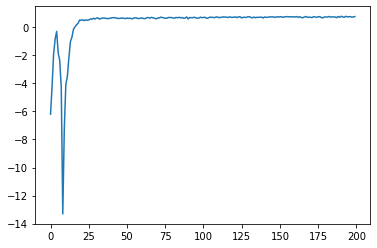

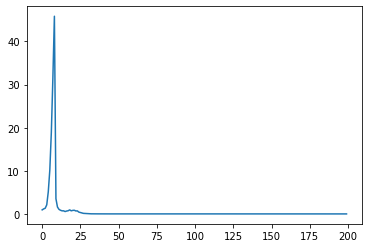

In [167]:
plt.plot(r_list)
print(np.round(theta, 2))
print(np.where(theta > 0.90)[0])
print(np.argsort(theta)[::-1])
plt.figure()
plt.plot(w_norm)

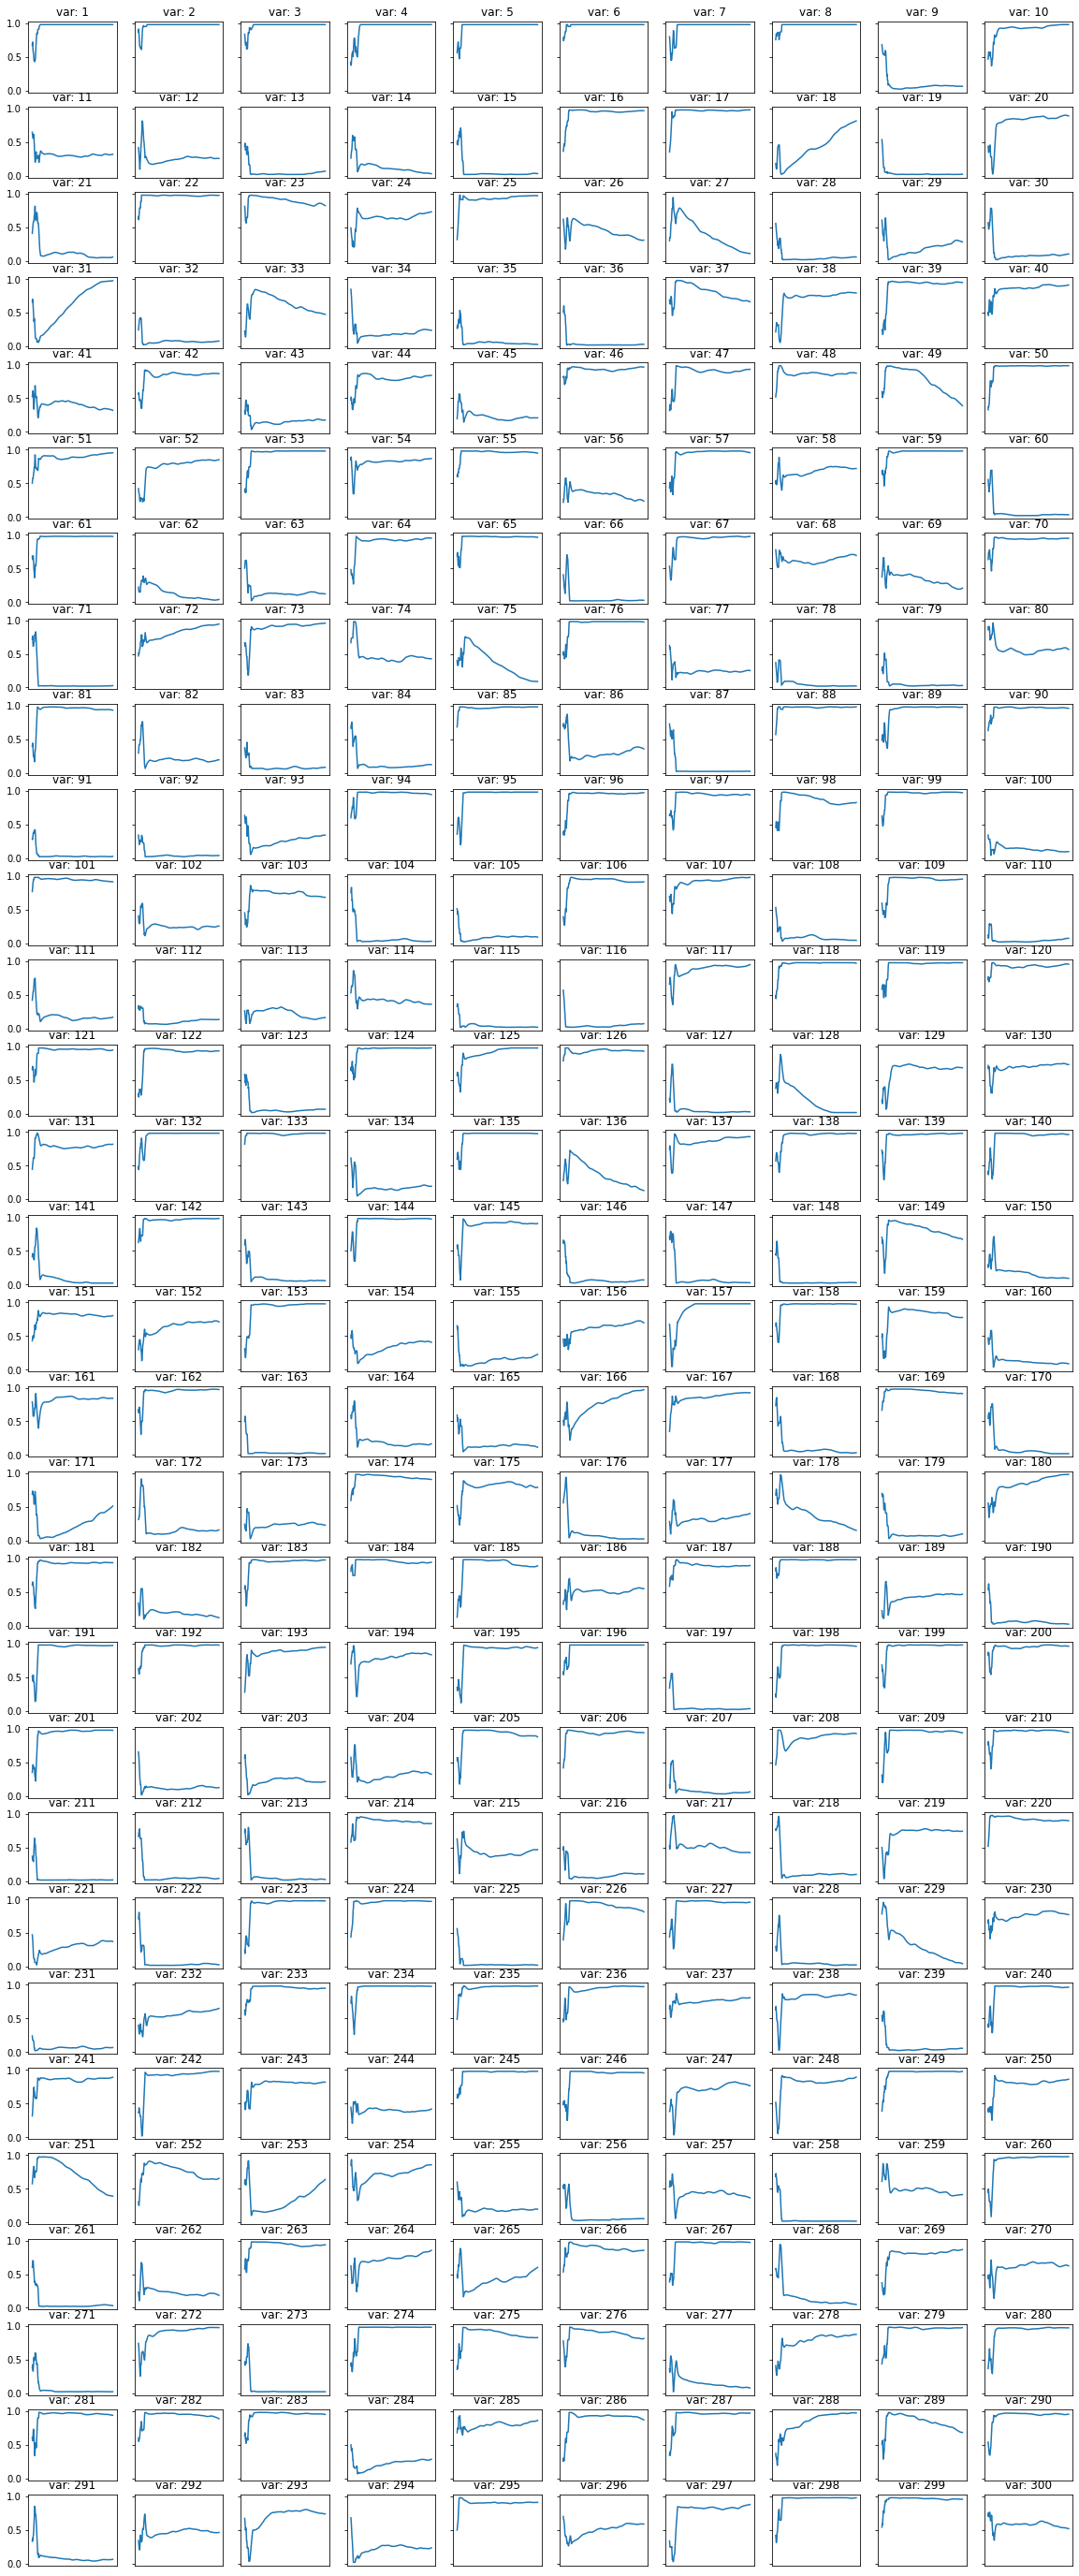

In [154]:
probs = np.array(p_list)
fig, axes = plt.subplots(int(n/10+0.9), 10, figsize=(20, 50), sharex=False, sharey=True)
# plt.subplots_adjust(
# top=0.965,
# bottom=0.09,
# left=0.03,
# right=0.83,
# hspace=0.52,
# wspace=0.18)
# fig.tight_layout()
num = 0
for i in range(int(n/10+0.9)):
    for j in range(10):
        axes[i, j].plot(pd.Series(np.array(probs)[:, num]).rolling(10).mean())
        axes[i, j].set_title(f'var: {num+1}')
        if i != int(n/8)-1: axes[i, j].set_xticks([]) 
        num += 1

In [168]:
print(np.where(theta > 0.9)[0])

num_selected = 8

npg = np.argsort(theta)[::-1][:num_selected]
print('npg: ', np.sort(npg))


lasso_aic = LassoLarsIC(criterion='aic', fit_intercept=False, normalize=False, noise_variance=np.std(Y))
lasso_aic.fit(X, Y)
aic = np.where(lasso_aic.coef_ != 0)[0]
print('lasso_aic: ', aic)


lasso_bic = LassoLarsIC(criterion='bic', fit_intercept=False, normalize=False, noise_variance=np.std(Y))
lasso_bic.fit(X, Y)
bic = np.where(lasso_bic.coef_ != 0)[0]
print('lasso_bic: ', bic)

print('lasso_cv')
lasso_cv = LassoCV(cv=5, fit_intercept=False, max_iter=3000)
lasso_cv.fit(X, Y)
print(np.where(lasso_cv.coef_ != 0)[0])


regr = RandomForestRegressor()
regr.fit(X, Y)
rf = np.argsort(regr.feature_importances_)[::-1][:num_selected]
print('random_forest: ', np.sort(rf))

[  0   1   2   3   4   5   6   7   9  10  12  14  16  18  20  21  23  25
  26  27  30  32  33  34  35  43  45  50  52  54  56  58  59  64  69  70
  71  73  77  79  83  85  86  87  88  90  95  98  99 100 103 104 106 112
 113 120 124 126 127 128 129 131 134 135 136 145 147 153 156 157 159 161
 162 170 172 175 176 181 182 183 188 193 195 198 199 202 210 211 212 214
 215 216 217 231 233 234 236 242 244 246 247 248 251 253 258 269 277 278
 279 280 281 282 284 286 288 291 292 294 296]
npg:  [  0   4   6   7  10  12 134 280]
lasso_aic:  [  0   1   2   3   4   5   6   7 189 252]
lasso_bic:  [0 1 2 3 4 5 6 7]
lasso_cv
[  0   1   2   3   4   5   6   7   9  23  28  49  59  73  76  92 101 156
 179 189 234 243 252 277]
random_forest:  [  1   2   3   4   5   6   7 221]


In [151]:
np.sort(replay_buffer[:,-1])[::-1]

array([ 0.90813289,  0.90511941,  0.90386469,  0.90379156,  0.90270801,
        0.9012443 ,  0.89736377,  0.89608799,  0.89531306,  0.89443534,
        0.89429105,  0.89427139,  0.89132372,  0.89043356,  0.8896705 ,
        0.88830183,  0.88807514,  0.88797788,  0.88791   ,  0.88632802,
        0.88543539,  0.8836788 ,  0.88301671,  0.88259009,  0.88207099,
        0.88184527,  0.88136145,  0.88126529,  0.88115677,  0.88076596,
        0.88031116,  0.88015419,  0.88004477,  0.88001551,  0.87973469,
        0.87926583,  0.8787511 ,  0.87849718,  0.87744743,  0.87695676,
        0.87625841,  0.87584673,  0.87567175,  0.87555634,  0.8755098 ,
        0.87544161,  0.87543263,  0.87535785,  0.87534346,  0.87520648,
        0.87515611,  0.87490871,  0.87480502,  0.87434085,  0.87432085,
        0.87389638,  0.87360667,  0.87321803,  0.8729707 ,  0.87287783,
        0.87275134,  0.87268975,  0.87251501,  0.87217209,  0.87216417,
        0.87198157,  0.87175078,  0.87111409,  0.87075727,  0.87

In [152]:
np.argsort(replay_buffer[:,-1])[::-1]

array([ 24, 430, 402, 143, 510,  14, 116,  99, 285, 447, 243,   5, 208,
       172, 144,  15, 288, 473, 324, 297, 266, 115, 396,  72,  45, 478,
       392, 333,  43, 270, 316, 311, 275, 290, 386, 222, 485, 500, 240,
       466, 440, 114, 435, 265,  32, 390, 463, 338, 260, 403,   0, 223,
       248, 254, 274, 181, 286, 284, 282, 111, 303,  84, 354, 326, 255,
       272, 150, 295, 179, 357, 431, 205, 432, 224, 467, 156, 378, 229,
       459, 470, 416, 213, 405, 271, 427, 446, 337, 160, 187, 269, 502,
       166, 468, 273, 401, 121, 118,  69, 448, 474, 206, 315, 379, 385,
       191, 328,  34, 276, 280, 130,  88, 235, 151, 189, 214, 203, 120,
       167, 414, 444, 343,  19, 307, 152, 325, 491, 359, 388, 163,  93,
       215, 376, 107, 241, 227, 329, 443, 100, 505, 228, 157, 437,  70,
       190, 199, 395,  26, 460, 211, 413,  62, 342, 268,  47, 347, 360,
       298, 164, 462, 489, 439, 278, 133,  12, 451,  74, 247, 476, 344,
       362, 506, 149, 226, 412, 433, 106, 477,  66, 131,  25, 42

In [153]:
np.where(replay_buffer[24, :-1] == 1)[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  15,  16,  17,  21,
        22,  24,  28,  30,  37,  38,  39,  41,  45,  46,  47,  50,  51,
        52,  53,  54,  56,  58,  60,  63,  64,  66,  67,  69,  71,  72,
        73,  75,  80,  84,  87,  88,  89,  93,  94,  95,  96,  97,  98,
        99, 100, 105, 106, 116, 117, 118, 119, 120, 121, 123, 124, 125,
       128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       143, 144, 148, 150, 151, 152, 154, 155, 156, 157, 158, 159, 161,
       165, 166, 167, 168, 170, 173, 179, 182, 183, 184, 187, 190, 191,
       192, 193, 194, 195, 197, 198, 199, 200, 203, 204, 205, 208, 209,
       213, 215, 218, 219, 222, 223, 225, 226, 229, 231, 232, 233, 234,
       235, 236, 237, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248,
       249, 251, 252, 253, 254, 258, 259, 262, 263, 264, 265, 266, 268,
       269, 271, 273, 274, 275, 277, 278, 279, 280, 281, 282, 284, 285,
       286, 287, 288, 289, 291, 292, 293, 294, 296, 297, 298], d

In [112]:
np.intersect1d(np.where(replay_buffer[383, :-1]== 1)[0], np.where(replay_buffer[167, :-1]== 1)[0])

array([  0,   3,   6,   7,  83, 134, 138, 202, 212, 249, 290], dtype=int64)